In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import minimize
from itertools import product
from tqdm import tqdm_notebook
from sklearn.model_selection import TimeSeriesSplit

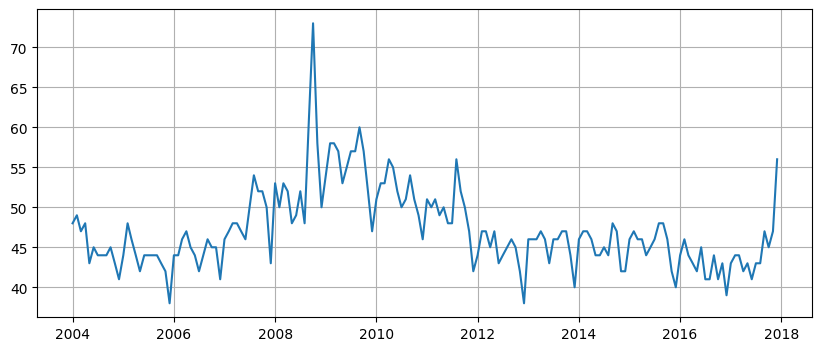

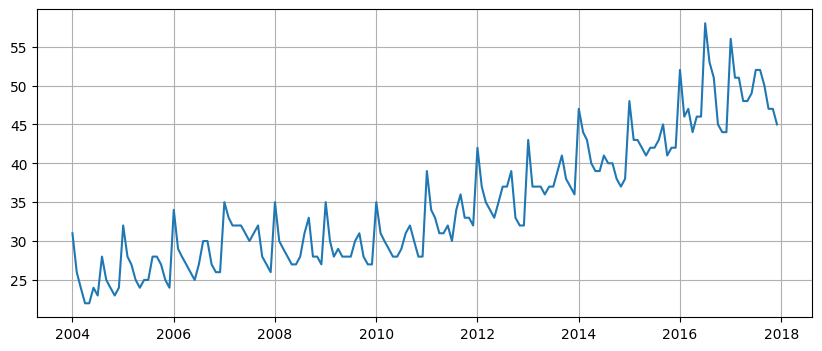

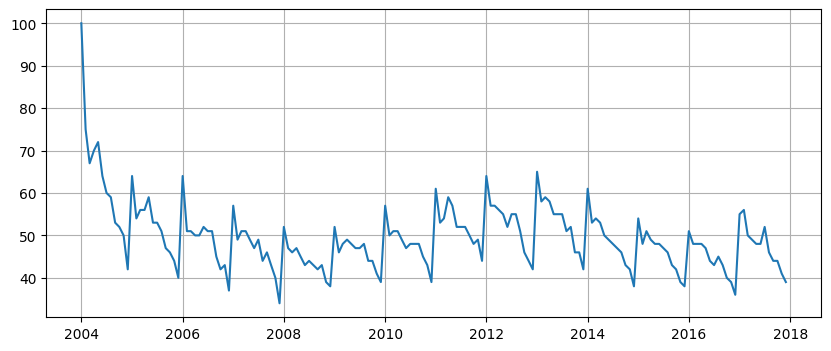

In [2]:
# read data for adverstisement of various fields
data = pd.read_csv("data/multiTimeline.csv", skiprows=2,  parse_dates=['Month'], index_col='Month')
data.columns = ['diet', 'gym', 'finance']

gym = data[['gym']]
finance = data[['finance']]
diet = data[['diet']]
# plot data
plt.figure(figsize=(10,4))
plt.plot(finance)
plt.grid(True)

plt.figure(figsize=(10,4))
plt.plot(gym)
plt.grid(True)

plt.figure(figsize=(10,4))
plt.plot(diet)
plt.grid(True)

In [68]:
def plotMovingAverage(series, window, plot_intervals=False,  plot_anomalies=False, upper_scale=1.96, lower_scale=1.96):
    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    # plot confidence intervals for smoothed values
    if plot_intervals:
        # from window as rolling mean is NaN for initial values
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        error_deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + lower_scale * error_deviation)
        upper_bond = rolling_mean + (mae + upper_scale * error_deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
            
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()


## Let's explore Finance Ads

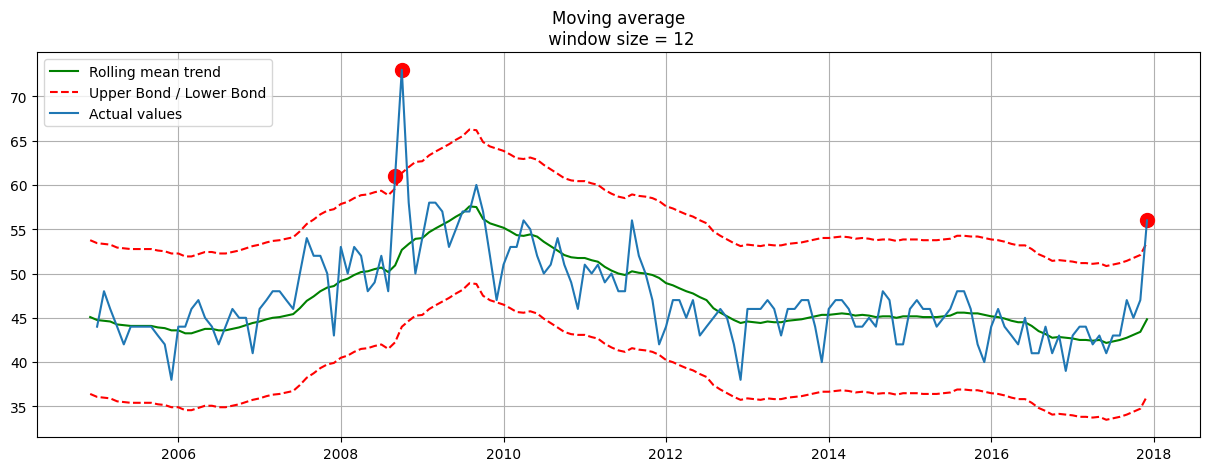

In [9]:
# smoothing for last 12 months
plotMovingAverage(finance, 12, True, True)


anonmalies are caught here quite well

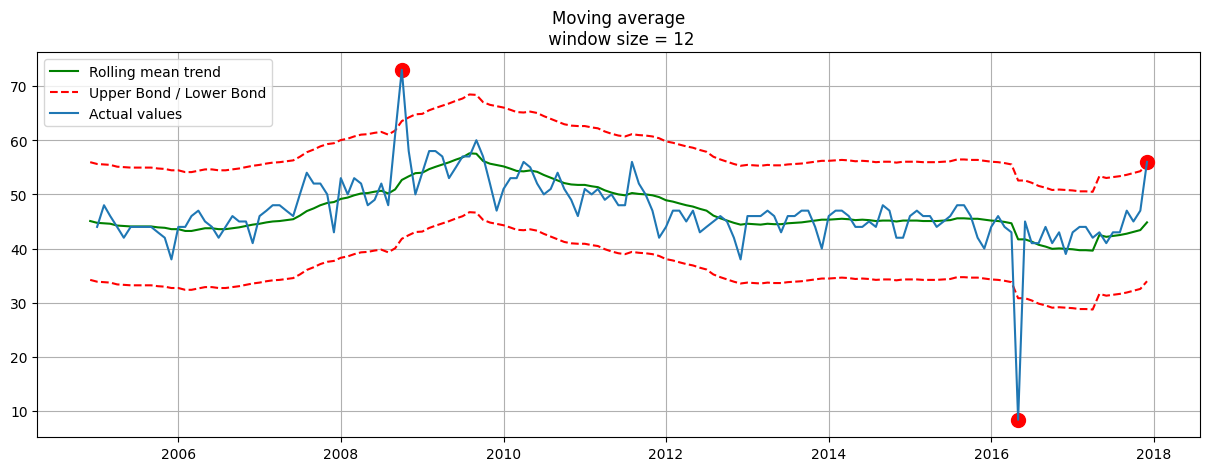

In [10]:
# create a random anomaly
finance_anomaly = finance.copy()
finance_anomaly.iloc[-20] = finance_anomaly.iloc[-20] * 0.2

# say we have 80% drop of ads 
plotMovingAverage(finance_anomaly, 12, True, True)

it catches this anomaly as well

## Let's try on gym ads

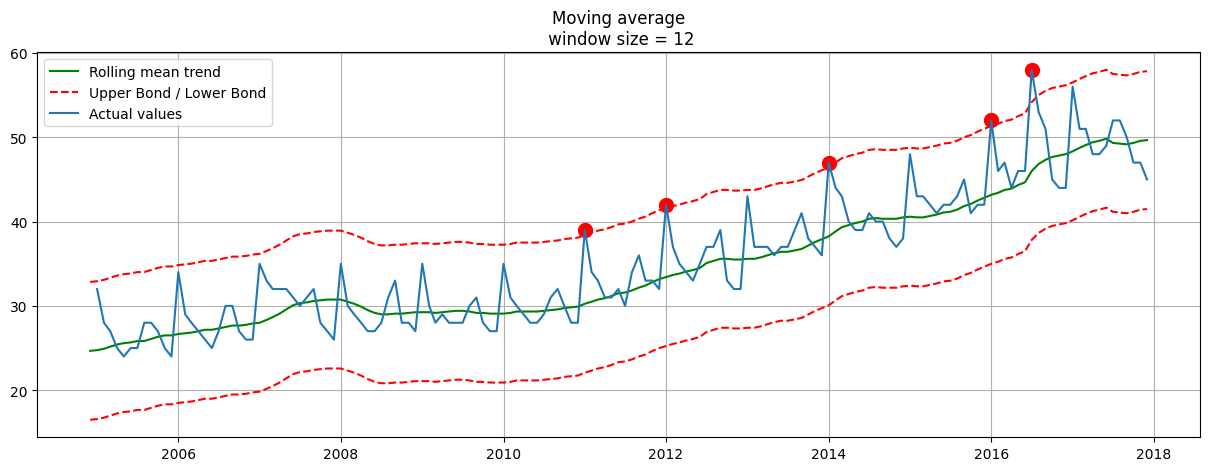

In [12]:
plotMovingAverage(gym, 12, True, True)

Let's look at diet ads

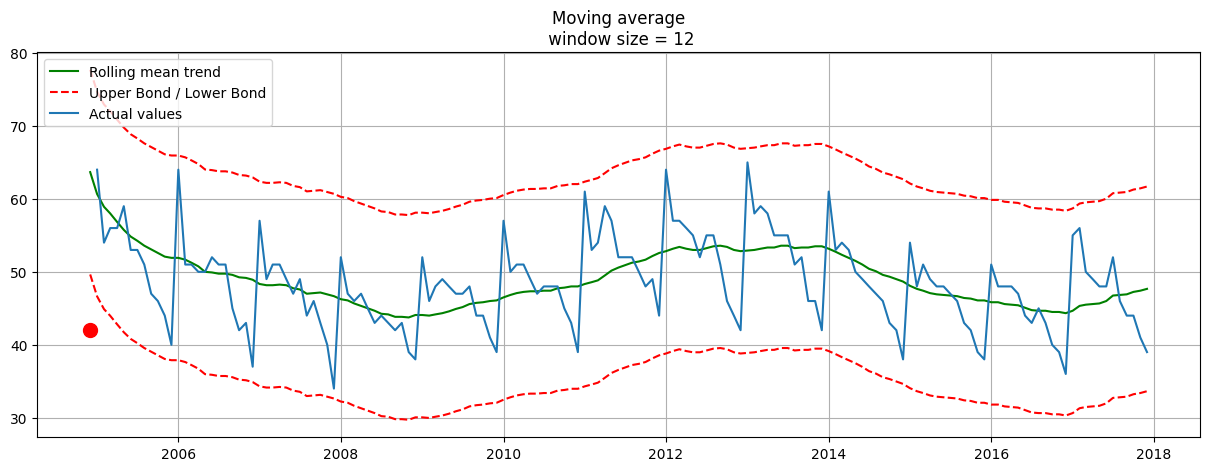

In [69]:
plotMovingAverage(diet, 12, True, True)

## Let's look at exponential smoothing for anomaly detection

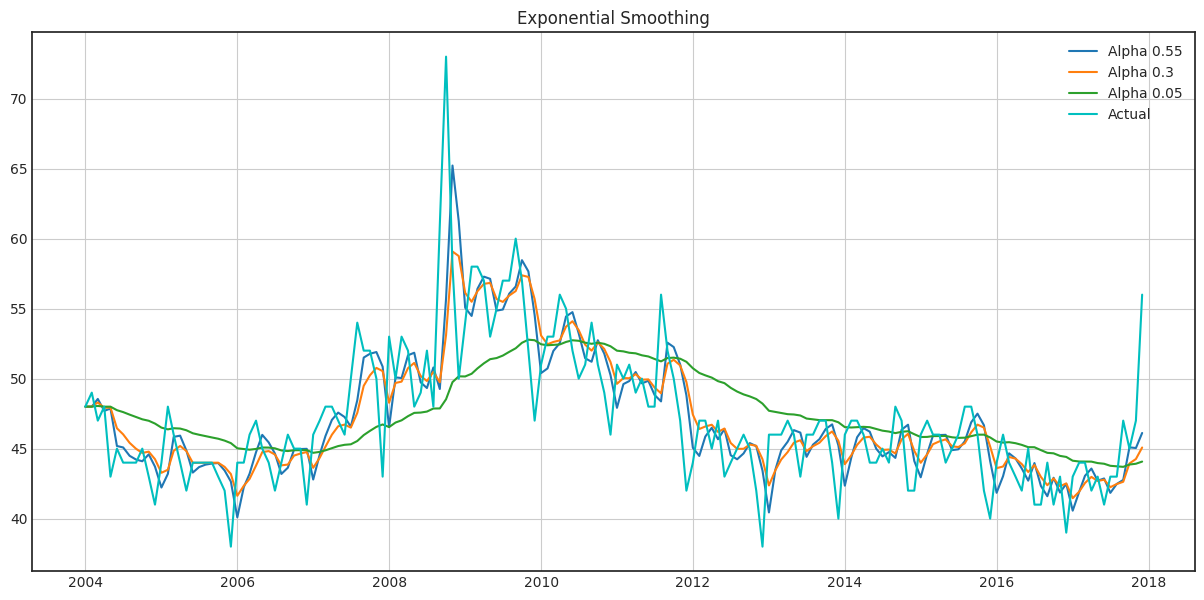

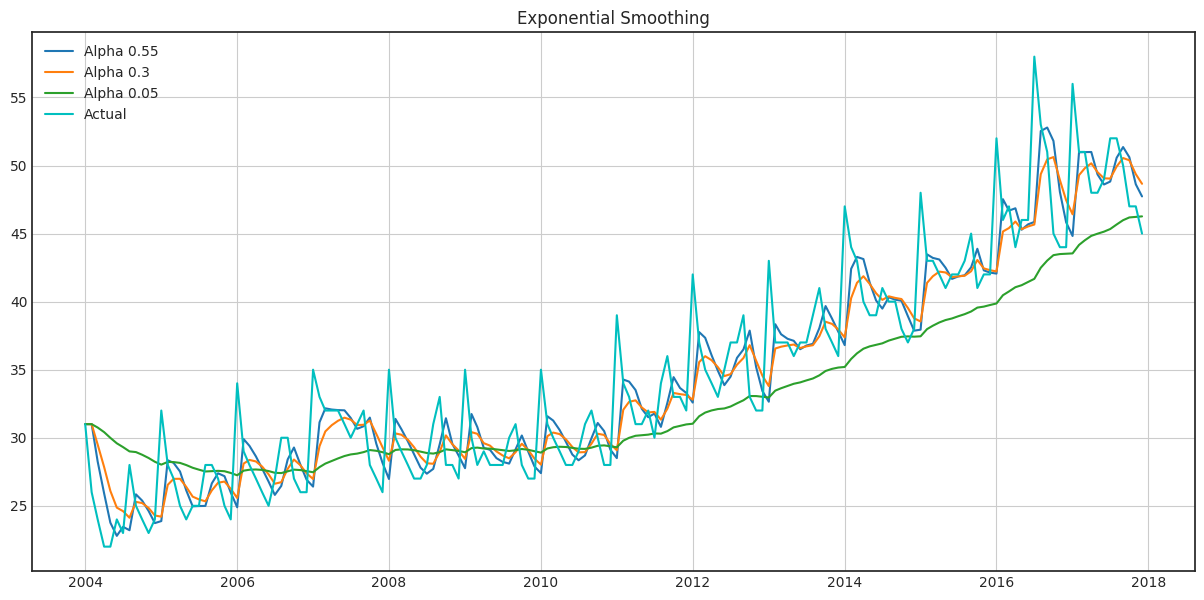

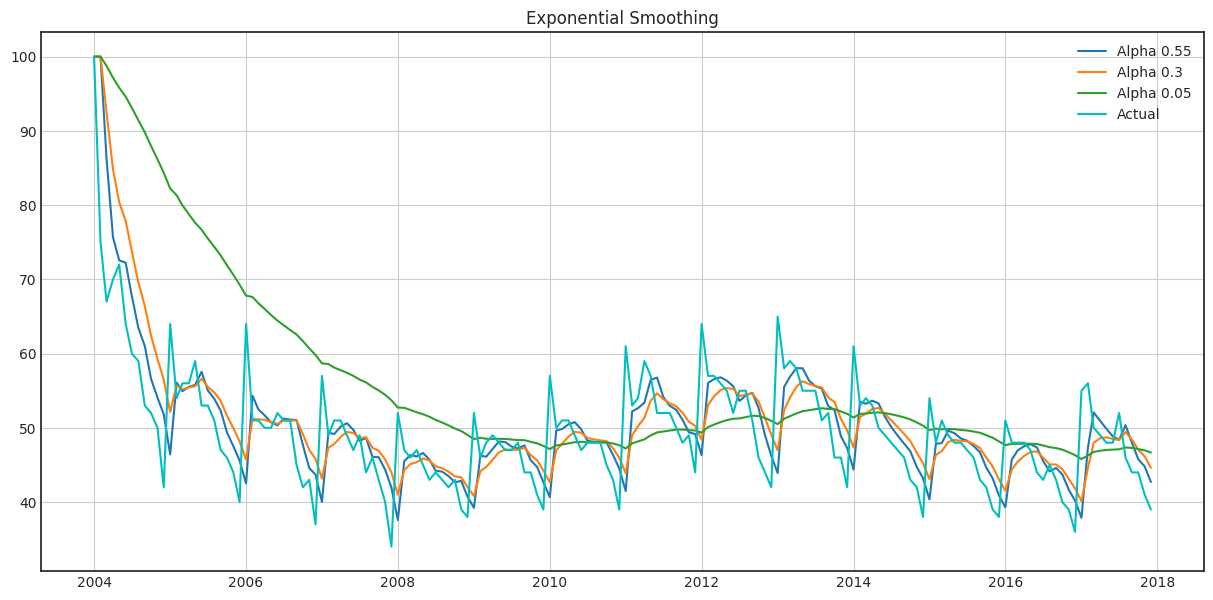

In [70]:
# using complex model: weighted average- more recent observation will have greater weight
def exponential_smoothing(series, alpha):
    
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    # result[n] = alpha * series[n] + (1 - alpha) * result[n-1]
    # The less α is the more influence previous model values have, 
    # and the smoother the series will get
    
    result = SimpleExpSmoothing(series).fit(smoothing_level=alpha)
    return result.fittedvalues
    
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);
        
plotExponentialSmoothing(finance, [0.55, 0.3, 0.05])        
plotExponentialSmoothing(gym, [0.55, 0.3, 0.05])     
plotExponentialSmoothing(diet, [0.55, 0.3, 0.05])     

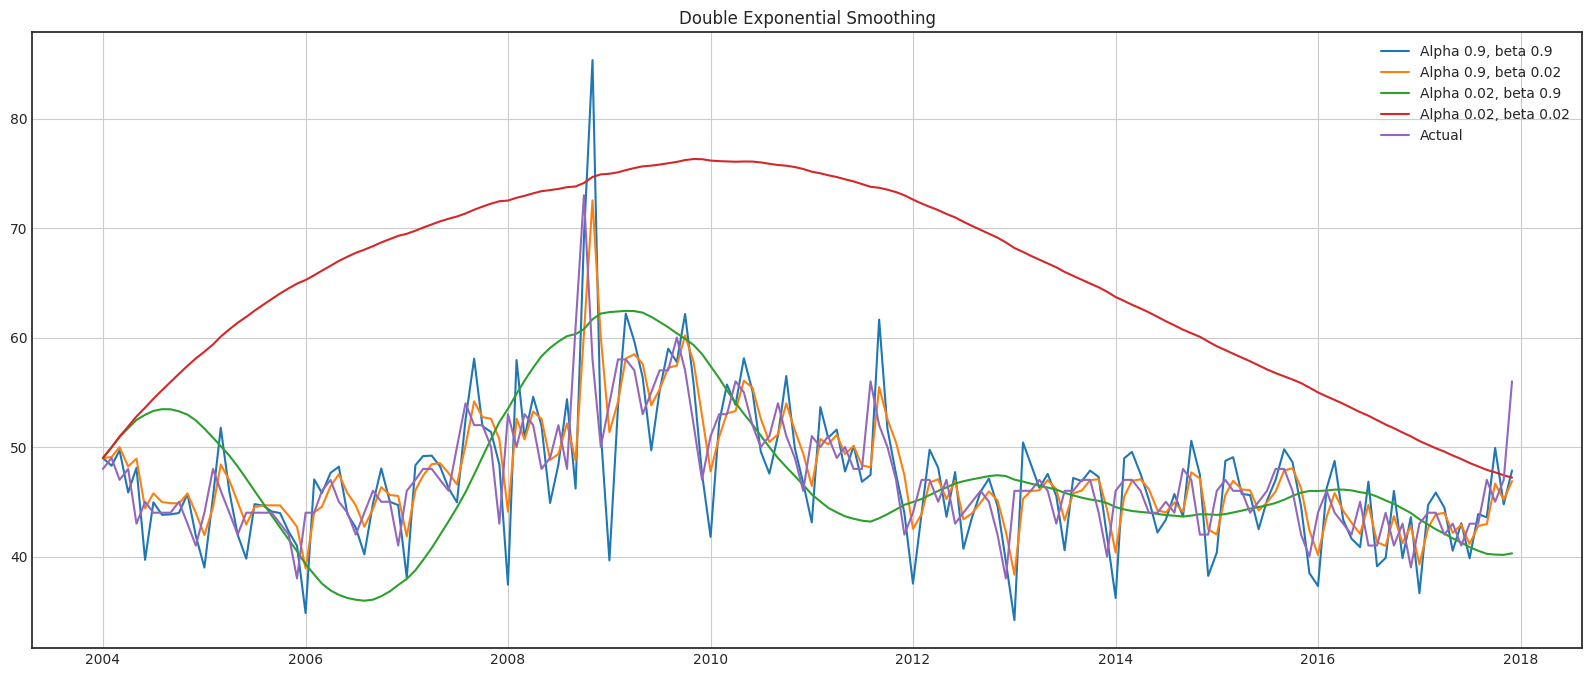

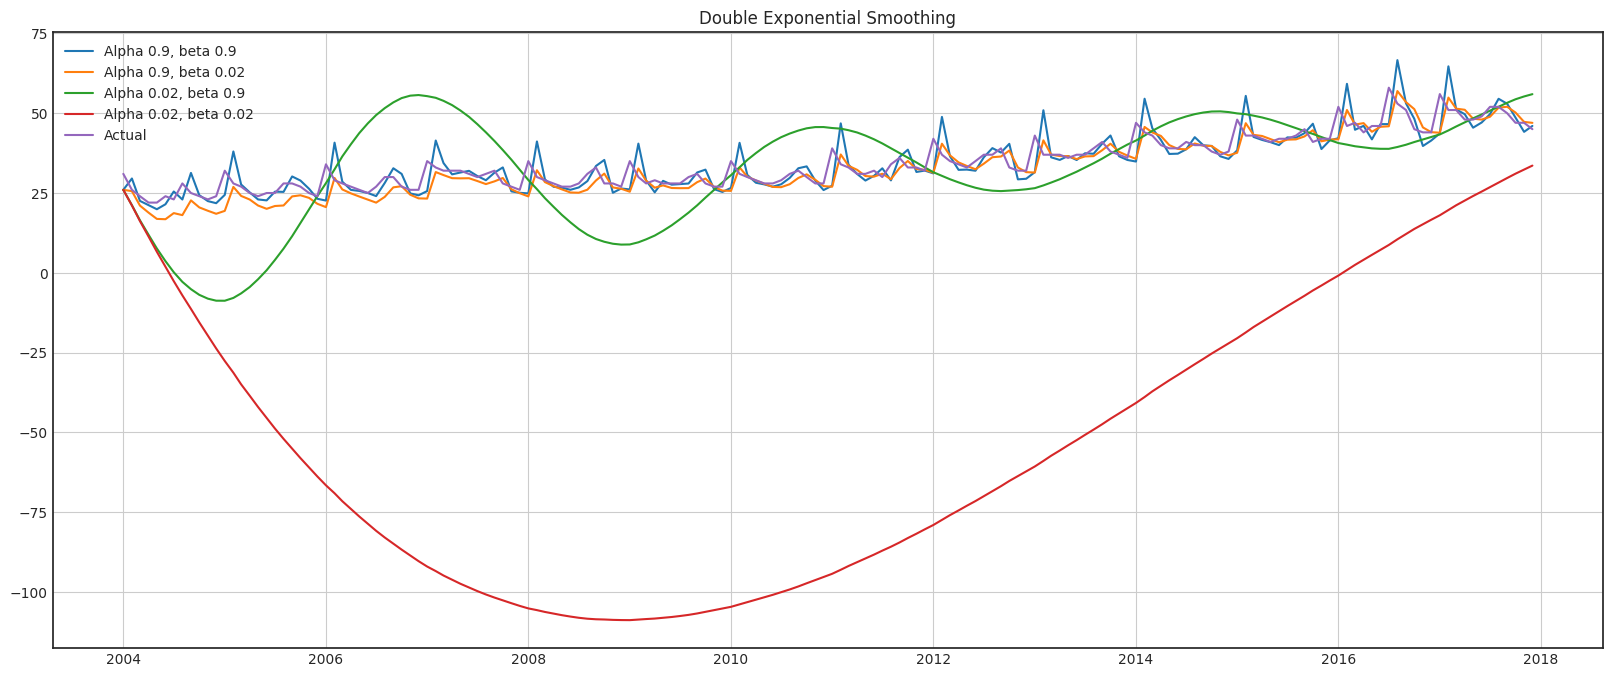

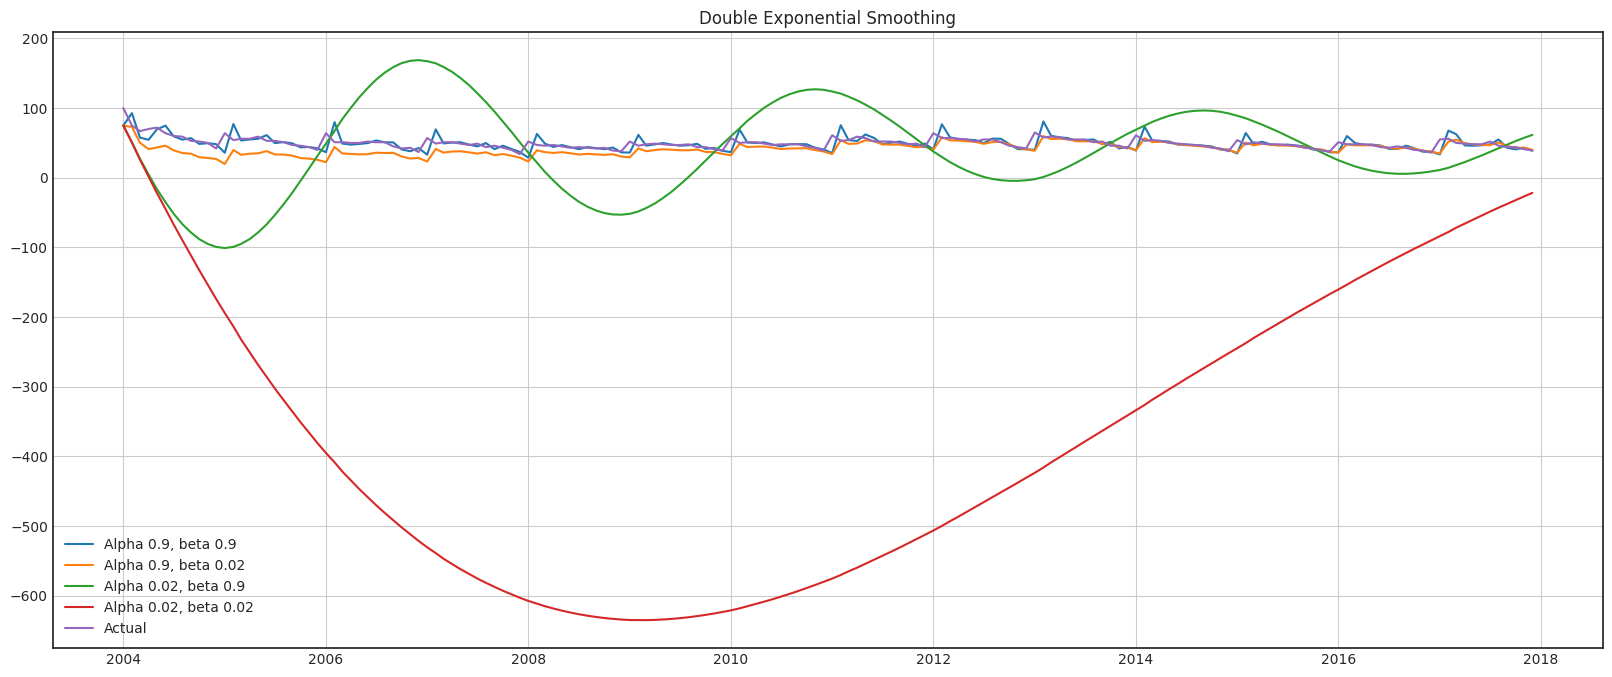

In [71]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    # last_level, level = level, alpha*value + (1-alpha)*(level+trend)
    # trend = beta*(level-last_level) + (1-beta)*trend
    # result = level+trend
    result = Holt(series).fit(smoothing_level=alpha, smoothing_slope=beta).fittedvalues
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)
        
plotDoubleExponentialSmoothing(finance, alphas=[0.9, 0.02], betas=[0.9, 0.02])
plotDoubleExponentialSmoothing(gym, alphas=[0.9, 0.02], betas=[0.9, 0.02])   
plotDoubleExponentialSmoothing(diet, alphas=[0.9, 0.02], betas=[0.9, 0.02])   

In [62]:
def plotHoltWinters(model, series, test, gamma, plot_intervals=False, plot_anomalies=False, scaling_factor=1.96, forecast_length=36):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
        gamma- how much portion of previous deviation (1-gamma) to be included in current deviation to detect anomaly
    """
    
    # forecast for test data and future data
    forecastedValues = model.forecast(len(test)+forecast_length)

    # combine model fitted values and forecasted values
    modelValues = pd.concat([model.fittedvalues, forecastedValues])

    plt.figure(figsize=(20, 10))
    plt.plot(modelValues, "g", label = "Model")
    plt.plot(series, "b", label = "Actual")
    
    # get error of actual series and (fitted values + test data)
    error = mean_absolute_percentage_error(series.values, modelValues[:len(series)].values)
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    

    # create series with index of timeseries as actual series + forecasted series
    predictedDeviation = pd.Series(index=modelValues.index)
    UpperBond = pd.Series(index=modelValues.index)
    LowerBond = pd.Series(index=modelValues.index)

    # set first value to be 0
    predictedDeviation[0] = 0
    
    # bond = fitted values +/- scalingfactor*deviation
    UpperBond[0] = (modelValues.values[0] + scaling_factor * predictedDeviation[0])    
    LowerBond[0] = (modelValues.values[0] - scaling_factor * predictedDeviation[0])
    
    # for training dataset
    for i in range(1, len(series)):
        # Deviation is calculated according to Brutlag algorithm.
        predictedDeviation[i] = (gamma * np.abs(series.values[i] - modelValues.values[i]) + (1-gamma)*predictedDeviation[i-1])
        UpperBond[i] = (modelValues.values[i] + scaling_factor * predictedDeviation[i])
        LowerBond[i] = (modelValues.values[i] - scaling_factor * predictedDeviation[i])
    
    # for forecasted dataset
    for i in range(len(series), len(modelValues)):
        # increase uncertainity on each next step by multiplying deviation to 1.01
        predictedDeviation[i] = (predictedDeviation[i-1] * 1.01)
        UpperBond[i] = (modelValues.values[i] + scaling_factor * predictedDeviation[i])
        LowerBond[i] = (modelValues.values[i] - scaling_factor * predictedDeviation[i])
    
    if plot_anomalies:
        anomalies = pd.Series(index=series.index)
        anomalies[series.values<LowerBond[:len(series)].values] = \
            series[series.values<LowerBond[:len(series)].values]
        anomalies[series.values>UpperBond[:len(series)]] = \
            series.values[series.values>UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=modelValues.index, y1=UpperBond, 
                         y2=LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(series[-1:].index, ymin=min(LowerBond), ymax=max(UpperBond), linestyles='dashed')
    plt.axvspan(series[-1:].index[0], modelValues[-1:].index[0], alpha=0.4, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

def timeseriesCVscore(params, series, loss_function=mean_squared_error, n_splits=3, slen=12):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):
        model = ExponentialSmoothing(values[train],
                            seasonal_periods=slen,
                            trend='add', 
                            seasonal='add',
                            ).fit(smoothing_level=alpha, 
                            smoothing_slope=beta, 
                            smoothing_seasonal=gamma)
        predictions = model.forecast(len(test))
        
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

### Let's fit the data into model first

1. gym data

In [63]:
# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
# TNC - Truncated Newton conjugate gradient
opt = minimize(timeseriesCVscore, x0=x, 
               args=(gym[:-12], mean_squared_error, 3), 
               method="TNC", bounds=((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.4689769240838676 0.0 0.0


                       ExponentialSmoothing Model Results                       
Dep. Variable:                      gym   No. Observations:                  107
Model:             ExponentialSmoothing   SSE                            260.365
Optimized:                         True   AIC                            127.150
Trend:                         Additive   BIC                            169.915
Seasonal:                      Additive   AICC                           134.923
Seasonal Periods:                    12   Date:                 Wed, 24 Apr 2024
Box-Cox:                          False   Time:                         11:16:04
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4689769                alpha                False
smoothing_trend          

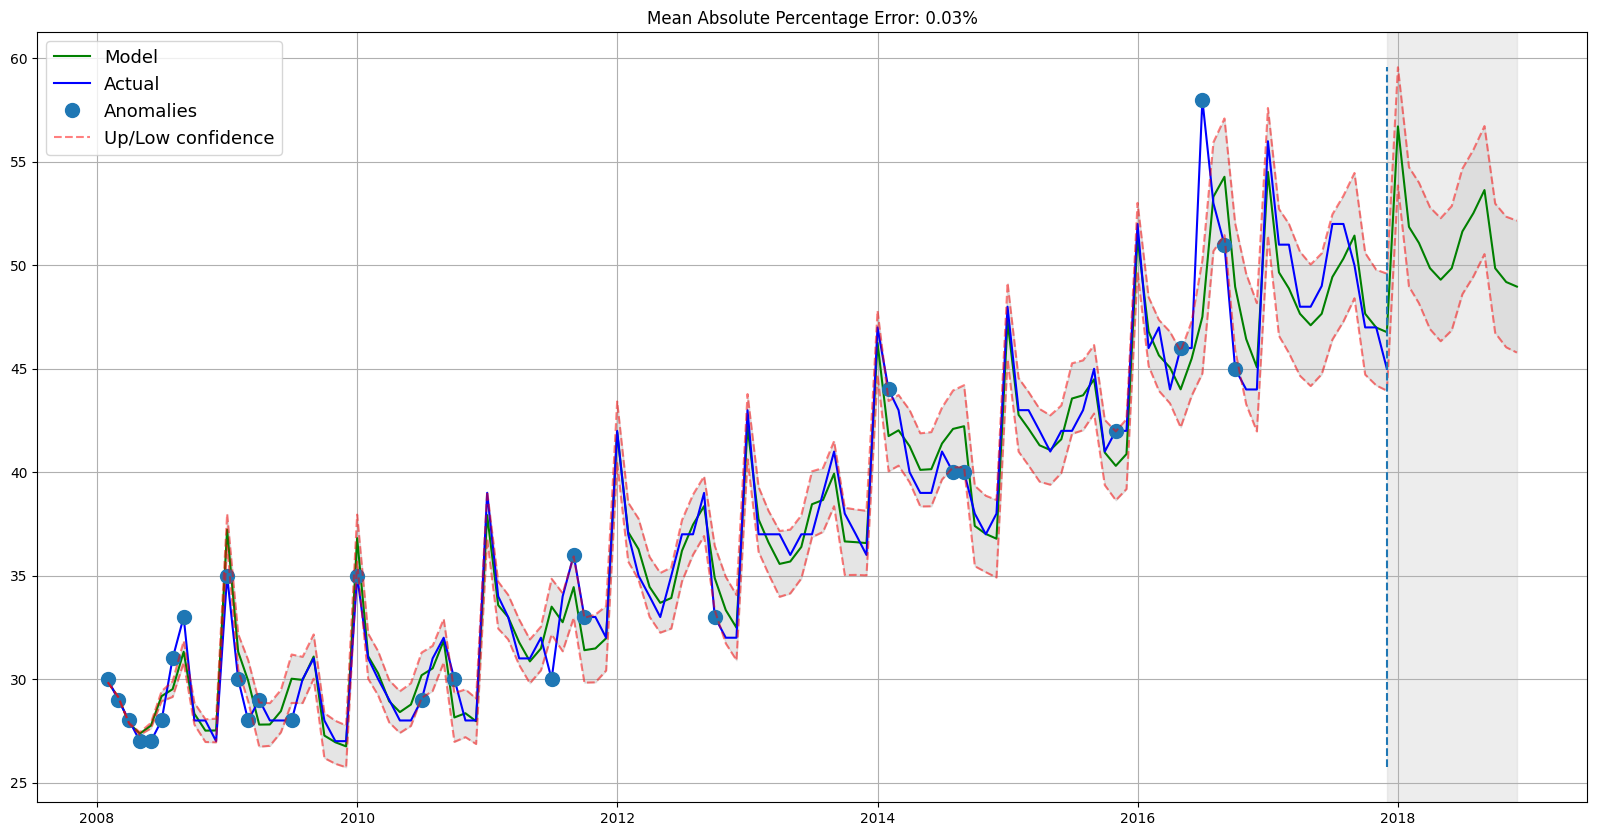

In [65]:
# Train the model...
model = ExponentialSmoothing(gym[49:-12] ,
                            seasonal_periods=12 ,
                            trend='add', 
                            seasonal='add',
                            ).fit(smoothing_level=alpha_final, 
                            smoothing_slope=beta_final, 
                            smoothing_seasonal=gamma_final)

print(model.summary())

plotHoltWinters(model, gym.gym[49:], gym.gym[-12:], plot_intervals=True, plot_anomalies=True, gamma=0.05, forecast_length=12)

2. Diet data

In [56]:
# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data.diet[:-12], mean_squared_error, 4), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

2.6004794984046953e-08 0.0 1.456237352925882e-10


                       ExponentialSmoothing Model Results                       
Dep. Variable:                     diet   No. Observations:                  156
Model:             ExponentialSmoothing   SSE                           1077.906
Optimized:                         True   AIC                            333.535
Trend:                         Additive   BIC                            382.333
Seasonal:                      Additive   AICC                           338.528
Seasonal Periods:                    12   Date:                 Wed, 24 Apr 2024
Box-Cox:                          False   Time:                         11:21:06
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4689769                alpha                False
smoothing_trend          

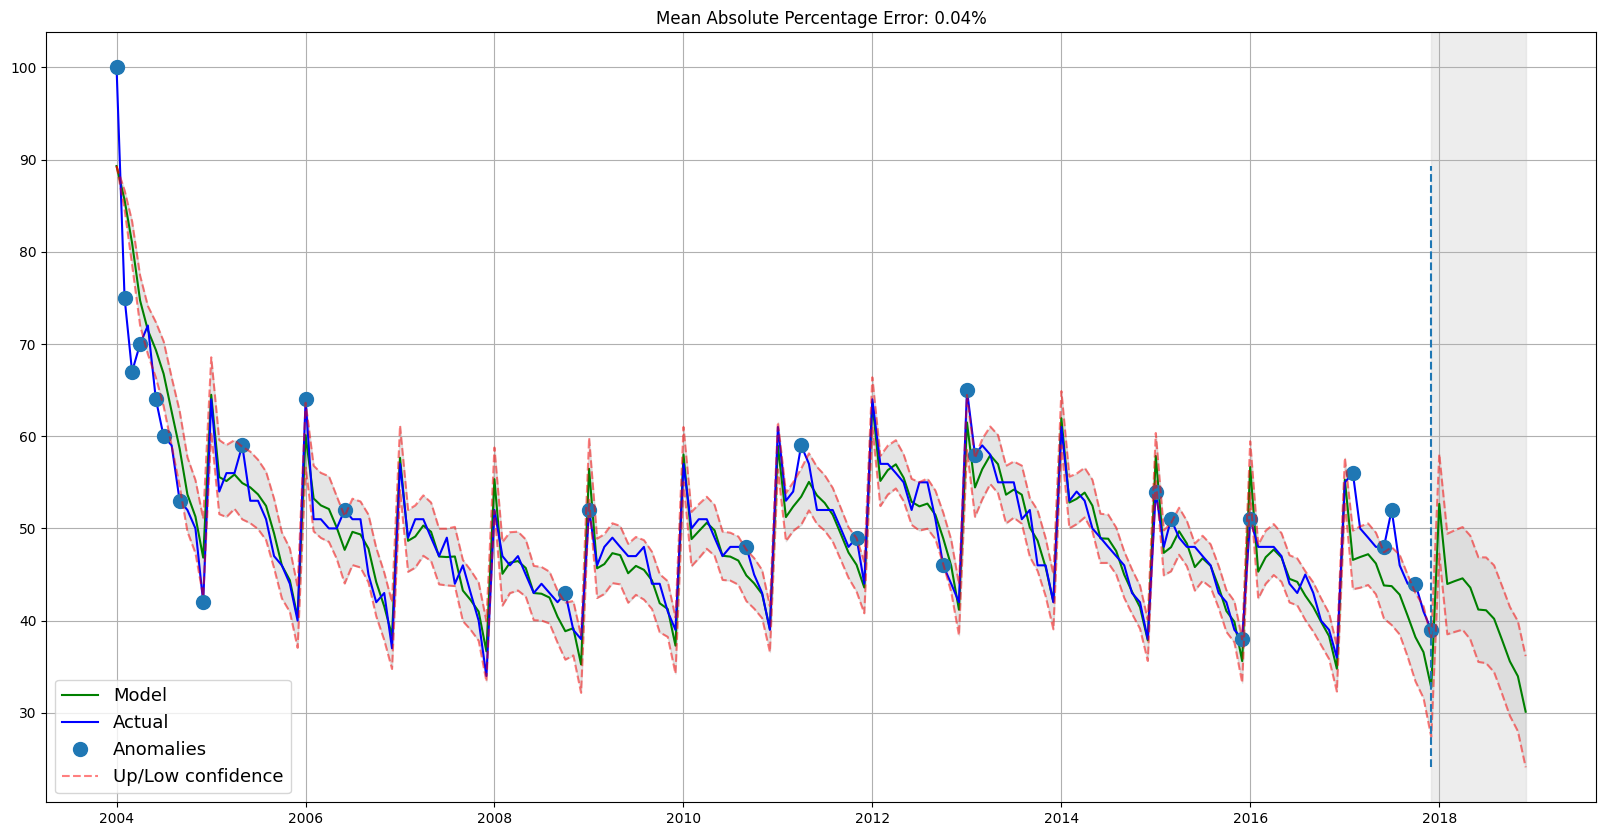

In [73]:
model = ExponentialSmoothing(data.diet[:-12] ,
                            seasonal_periods=12 ,
                            trend='add', 
                            seasonal='add',
                            ).fit(smoothing_level=alpha_final, 
                            smoothing_slope=beta_final, 
                            smoothing_seasonal=gamma_final)

print(model.summary())

plotHoltWinters(model, data.diet, data.diet[-12:], plot_intervals=True, plot_anomalies=True, gamma=0.05, forecast_length=12)


3. Finance data

In [77]:
# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data.finance[:-12], mean_squared_log_error, 4), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.0 6.961714538178398e-11 1.1243886932632563e-09


                       ExponentialSmoothing Model Results                       
Dep. Variable:                  finance   No. Observations:                  156
Model:             ExponentialSmoothing   SSE                            914.205
Optimized:                         True   AIC                            307.839
Trend:                         Additive   BIC                            356.637
Seasonal:                      Additive   AICC                           312.832
Seasonal Periods:                    12   Date:                 Wed, 24 Apr 2024
Box-Cox:                          False   Time:                         11:24:08
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5000000                alpha                False
smoothing_trend          

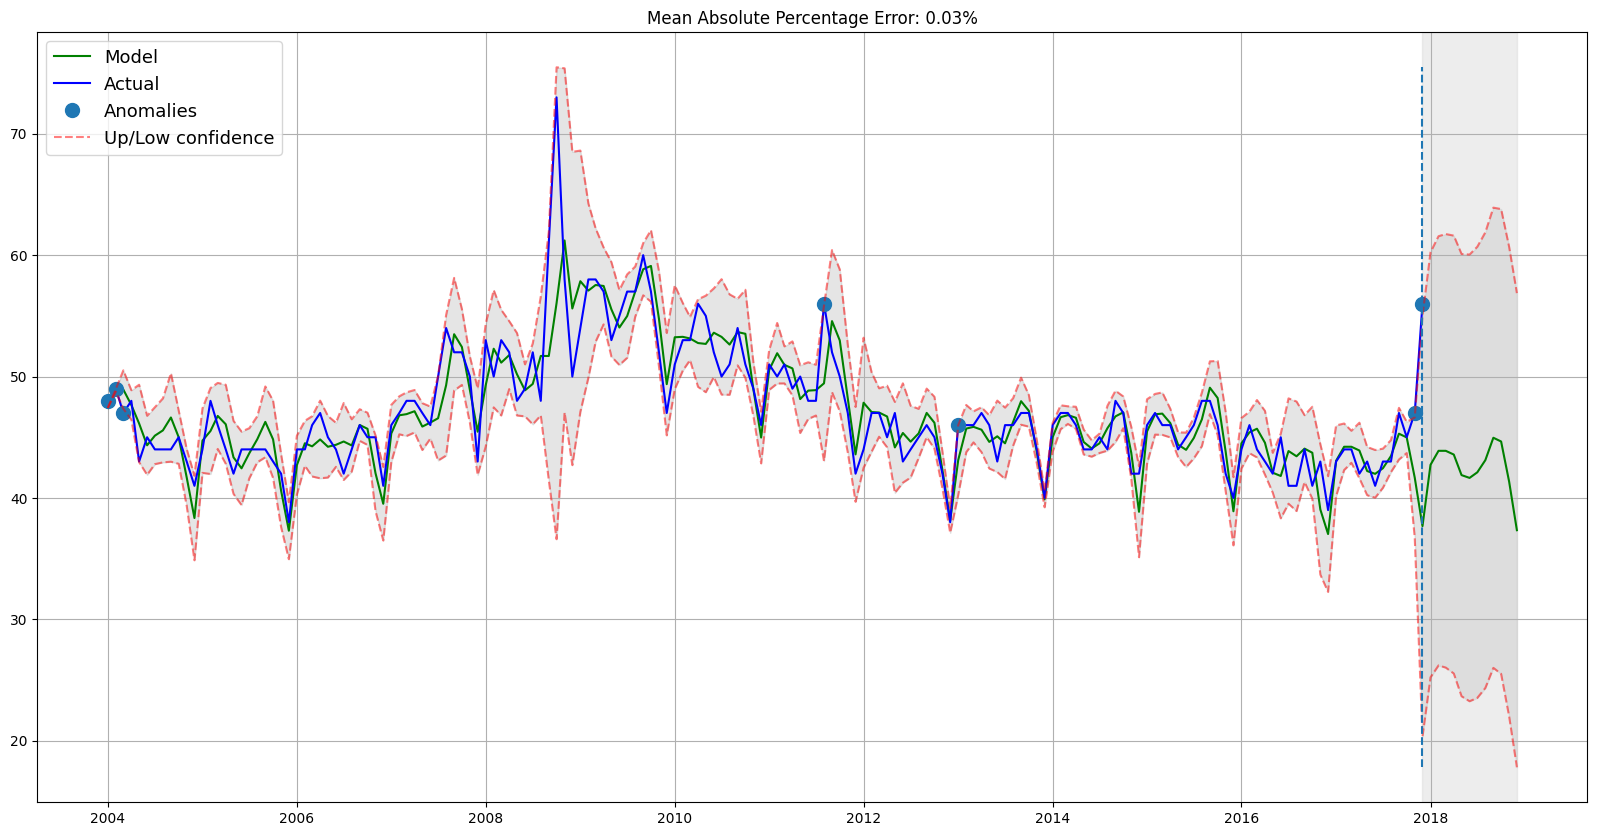

In [81]:
model = ExponentialSmoothing(data.finance[:-12] ,
                            seasonal_periods=12 ,
                            trend='add', 
                            seasonal='add',
                            ).fit(smoothing_level=0.5, 
                            smoothing_slope=beta_final, 
                            smoothing_seasonal=gamma_final)

print(model.summary())

plotHoltWinters(model, data.finance, data.finance[-12:], plot_intervals=True, plot_anomalies=True, gamma=0.05, forecast_length=12)


# SARIMAX for anomaly detection

In [10]:
# DICKEY FULLER TEST
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")


def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ###################################
        # DICKEY FULLER
        # x(t)=rho*x(t−1)+e(t)
        # 
        #### as we increase the rho value the deviation of time series increases
        #### around its mean value
        #
        #### for rho=1 there will be nothing that will bring x(t) to its mean value
        #### back once it reaches the critical value and hence time series become
        #### non stationary. for this first difference will make series stationary 
        #
        # for details look medium tutorial file
        ###################################
        adf_test(y)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax)
        plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
   
   
def plotSARIMA(series, model, n_steps, s, d, gamma, scaling_factor=1.96, plot_anomalies=False, plot_intervals=False):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(20, 10))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='g', label="model")
    plt.plot(data.actual, "b", label="actual")
    
    # create series with index of timeseries as actual series + forecasted series
    predictedDeviation = pd.Series(index=forecast.index)
    # set first value to be 0
    predictedDeviation[s+d+0] = 0
    
    # bond = fitted values +/- scalingfactor*deviation
    UpperBond = pd.Series(index=forecast.index)
    UpperBond[s+d+0] = (forecast.values[s+d+0] + scaling_factor * predictedDeviation[s+d+0])
    LowerBond = pd.Series(index=forecast.index)
    LowerBond[s+d+0] = (forecast.values[s+d+0] - scaling_factor * predictedDeviation[s+d+0])
    
    # for training dataset
    for i in range(s+d+1, len(series)):
        # Deviation is calculated according to Brutlag algorithm.
        predictedDeviation[i] = (gamma * np.abs(series.values[i] - forecast.values[i]) + (1-gamma)*predictedDeviation[i-1])
        UpperBond[i] = (forecast.values[i] + scaling_factor * predictedDeviation[i])
        LowerBond[i] = (forecast.values[i] - scaling_factor * predictedDeviation[i])
    
    # for forecasted dataset
    for i in range(len(series), len(forecast)):
        # increase uncertainity on each next step by multiplying deviation to 1.01
        predictedDeviation[i] = (predictedDeviation[i-1] * 1.01)
        UpperBond[i] = (forecast.values[i] + scaling_factor * predictedDeviation[i])
        LowerBond[i] = (forecast.values[i] - scaling_factor * predictedDeviation[i])
    
    if plot_anomalies:
        anomalies = pd.Series(index=series.index)
        anomalies[data.actual.values<LowerBond[:len(data)].values] = \
            data.actual[data.actual.values<LowerBond[:len(data)].values]
        anomalies[data.actual.values>UpperBond[:len(data)]] = \
            data.actual.values[data.actual.values>UpperBond[:len(data)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=forecast.index, y1=UpperBond, 
                         y2=LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(series.index[-1], ymin=min(LowerBond[s+d:]), ymax=max(UpperBond[s+d:]), linestyles='dashed')
    plt.axvspan(series.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);


def getBestOrder(parameters_list, train, test):
    """
        Return dataframe with parameters and corresponding AIC, RMSE
        
        parameters_list - list with (p, q, q, P, D, Q, S) tuples
        train- series to train model
        test- series to test model
    """
    # one with lowest aic and bic should be the choice
    results = []
    best_rmse=float("inf")

    for param in tqdm_notebook(parameters_list):
            try:
                model = SARIMAX(train,
                              order=(param[0], param[1], param[2]),
                              seasonal_order=(param[3], param[4], param[5], param[6]),
                              enforce_stationarity=False,
                              enforce_invertibility=False).fit(disp=False)
                forecast = model.forecast(len(test))
                rmse = np.sqrt(mean_squared_error(forecast, test))
                print('ARIMA{} - AIC:{} - RMSE:{}'.format(param, model.aic, rmse))
        
                if best_rmse>rmse:
                    best_params = param
                    best_rmse=rmse
                results.append([param, model.aic, rmse])
            except:
                continue

    print("RMSE- {}\nBest p,d,q, P,D,Q,S- {}".format(best_rmse, best_params))
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic', 'rmse']

    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='rmse', ascending=True).reset_index(drop=True)
    
    return result_table


1. Gym data

Augmented Dickey-Fuller Test: 
ADF test statistic        0.911155
p-value                   0.993234
# lags used              14.000000
# observations          153.000000
critical value (1%)      -3.473830
critical value (5%)      -2.880623
critical value (10%)     -2.576945
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


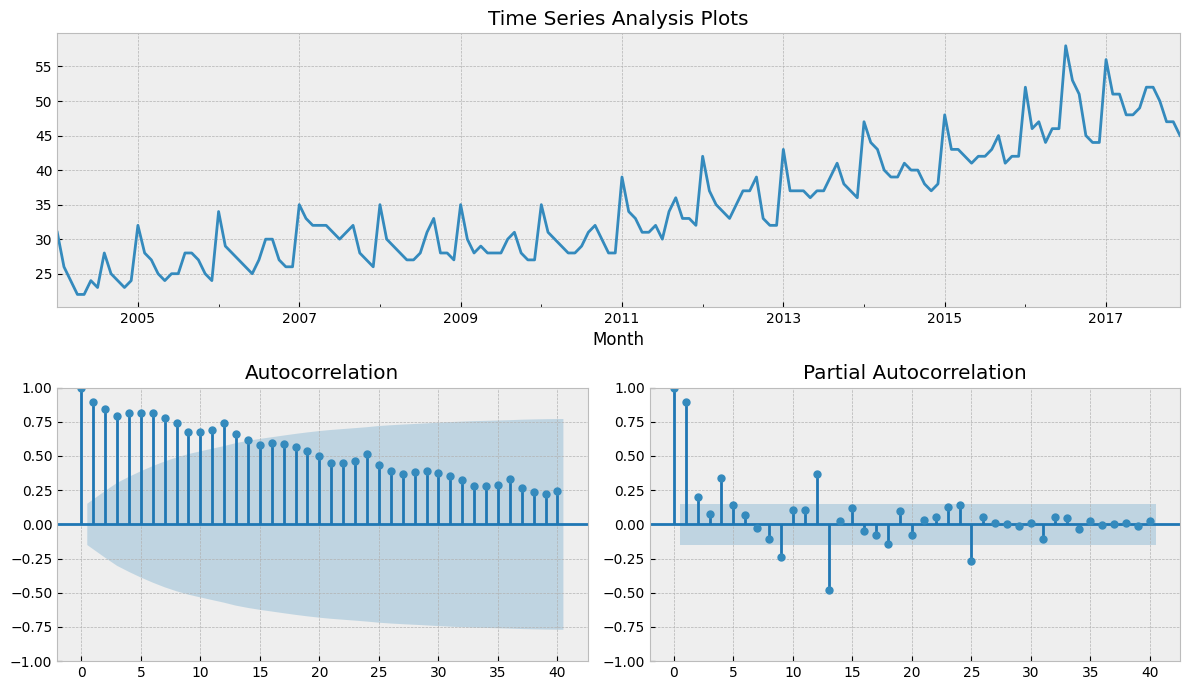

In [17]:
# check variance and trend through first plot
tsplot(data.gym, lags=40)

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.490641
p-value                   0.117768
# lags used              12.000000
# observations          143.000000
critical value (1%)      -3.476927
critical value (5%)      -2.881973
critical value (10%)     -2.577665
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


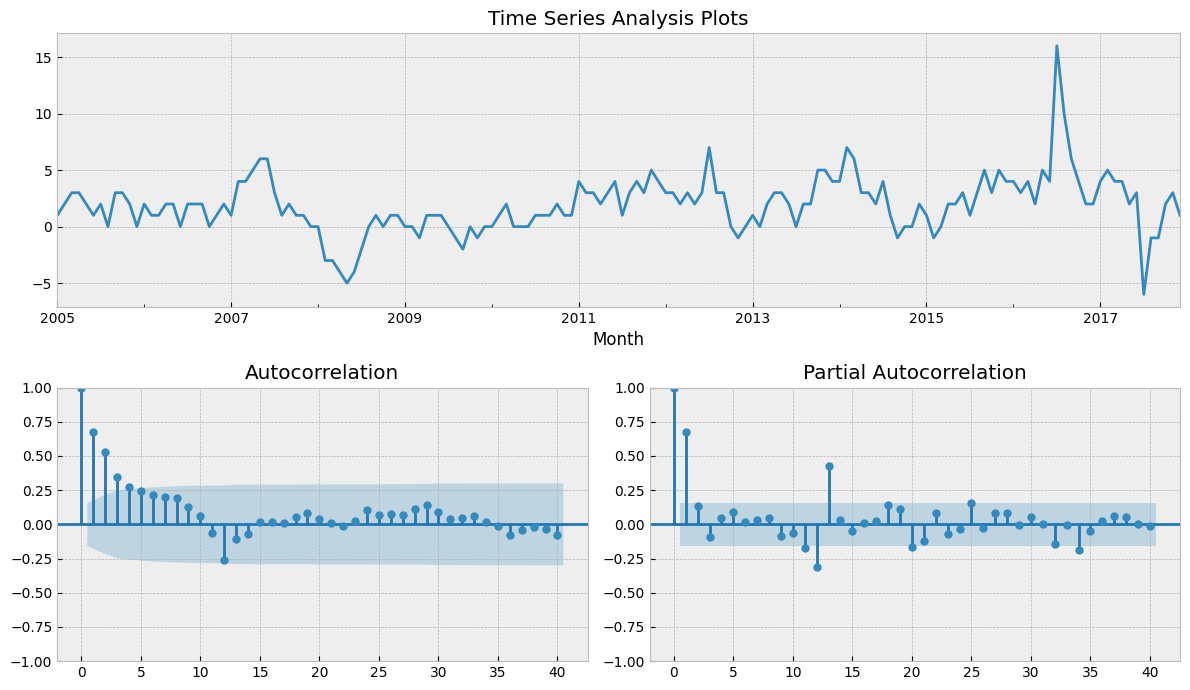

In [18]:
# remove seasonality for 12 months
gym_diff = data.gym.diff(12)
tsplot(gym_diff[12:], lags=40)

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.353545
p-value                   0.000004
# lags used              11.000000
# observations          143.000000
critical value (1%)      -3.476927
critical value (5%)      -2.881973
critical value (10%)     -2.577665
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


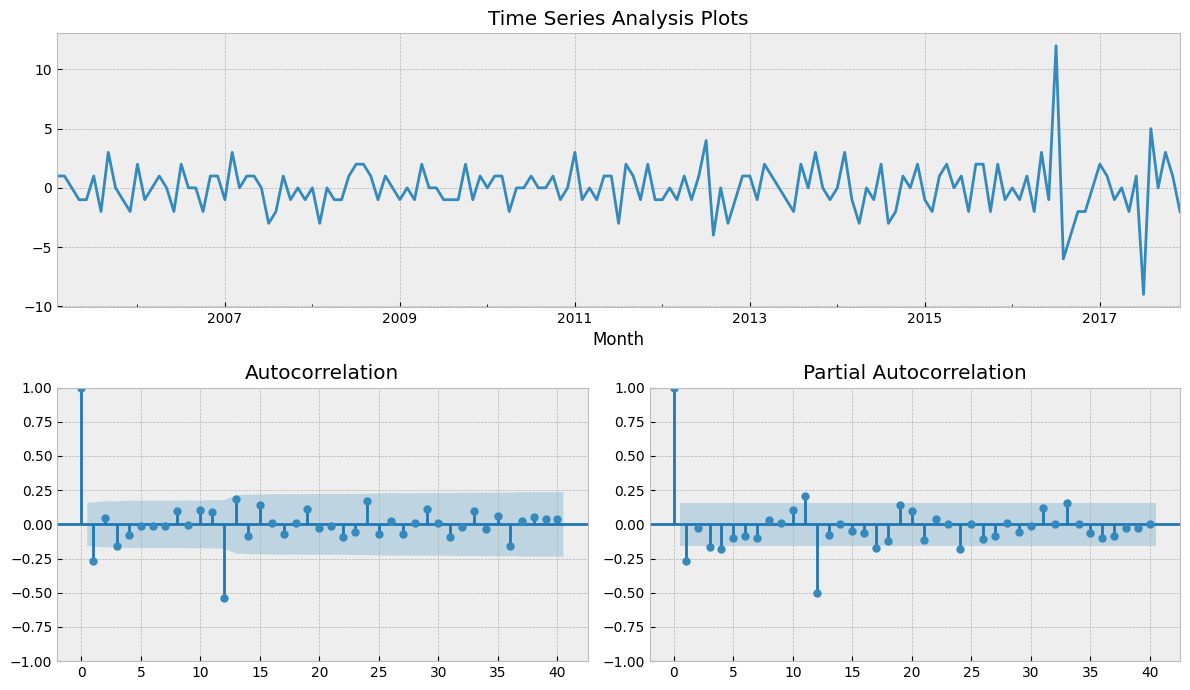

In [19]:
# lets take difference
gym_diff_ = gym_diff.diff(1)
tsplot(gym_diff_[13:], lags=40)

In [20]:
ps = range(0, 3)
d=[1] 
qs = range(0, 3)
Ps = range(0, 3)
D=[1] 
Qs = range(0, 3)
s = [12] # season length is still 1
# creating list with all the possible combinations of parameters
parameters = product(ps, d, qs, Ps, D, Qs, s)
parameters_list = list(parameters)
print(len(parameters_list))
    
train = data.gym.iloc[:-24]
test = data.gym.iloc[-24:]

result_table = getBestOrder(parameters_list, train, test)

81


  0%|          | 0/81 [00:00<?, ?it/s]

ARIMA(0, 1, 0, 0, 1, 0, 12) - AIC:478.76669331892356 - RMSE:3.2659863237199755
ARIMA(0, 1, 0, 0, 1, 1, 12) - AIC:387.8645185014343 - RMSE:3.0671523765229924


ARIMA(0, 1, 0, 0, 1, 2, 12) - AIC:334.6677706111422 - RMSE:3.083794190396526
ARIMA(0, 1, 0, 1, 1, 0, 12) - AIC:398.0542082185381 - RMSE:3.115335443619589
ARIMA(0, 1, 0, 1, 1, 1, 12) - AIC:378.081604727919 - RMSE:3.160237574079789
ARIMA(0, 1, 0, 1, 1, 2, 12) - AIC:335.6364008934219 - RMSE:3.0352465153358623
ARIMA(0, 1, 0, 2, 1, 0, 12) - AIC:354.21828094815714 - RMSE:3.017762034337096
ARIMA(0, 1, 0, 2, 1, 1, 12) - AIC:341.9575112143721 - RMSE:3.0875927683855258
ARIMA(0, 1, 0, 2, 1, 2, 12) - AIC:337.13874949250965 - RMSE:3.199945262545023
ARIMA(0, 1, 1, 0, 1, 0, 12) - AIC:470.1997163543871 - RMSE:3.30137449760946
ARIMA(0, 1, 1, 0, 1, 1, 12) - AIC:377.10480135593247 - RMSE:3.221966969911324
ARIMA(0, 1, 1, 0, 1, 2, 12) - AIC:330.1467863880017 - RMSE:3.1864510365999914
ARIMA(0, 1, 1, 1, 1, 0, 12) - AIC:391.60635710607534 - RMSE:3.160436805328679
ARIMA(0, 1, 1, 1, 1, 1, 12) - AIC:370.41133694183367 - RMSE:3.267657989206951
ARIMA(0, 1, 1, 1, 1, 2, 12) - AIC:331.9214683739124 - RMSE:3.145983524

(4, 1, 4, 1, 1, 1, 12)


                                     SARIMAX Results                                      
Dep. Variable:                                gym   No. Observations:                  119
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -208.805
Date:                            Thu, 25 Apr 2024   AIC                            427.611
Time:                                    13:54:47   BIC                            440.928
Sample:                                02-01-2008   HQIC                           433.008
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2583      0.085     -3.025      0.002      -0.426      -0.091
ar.L2          0.0005      0.063   

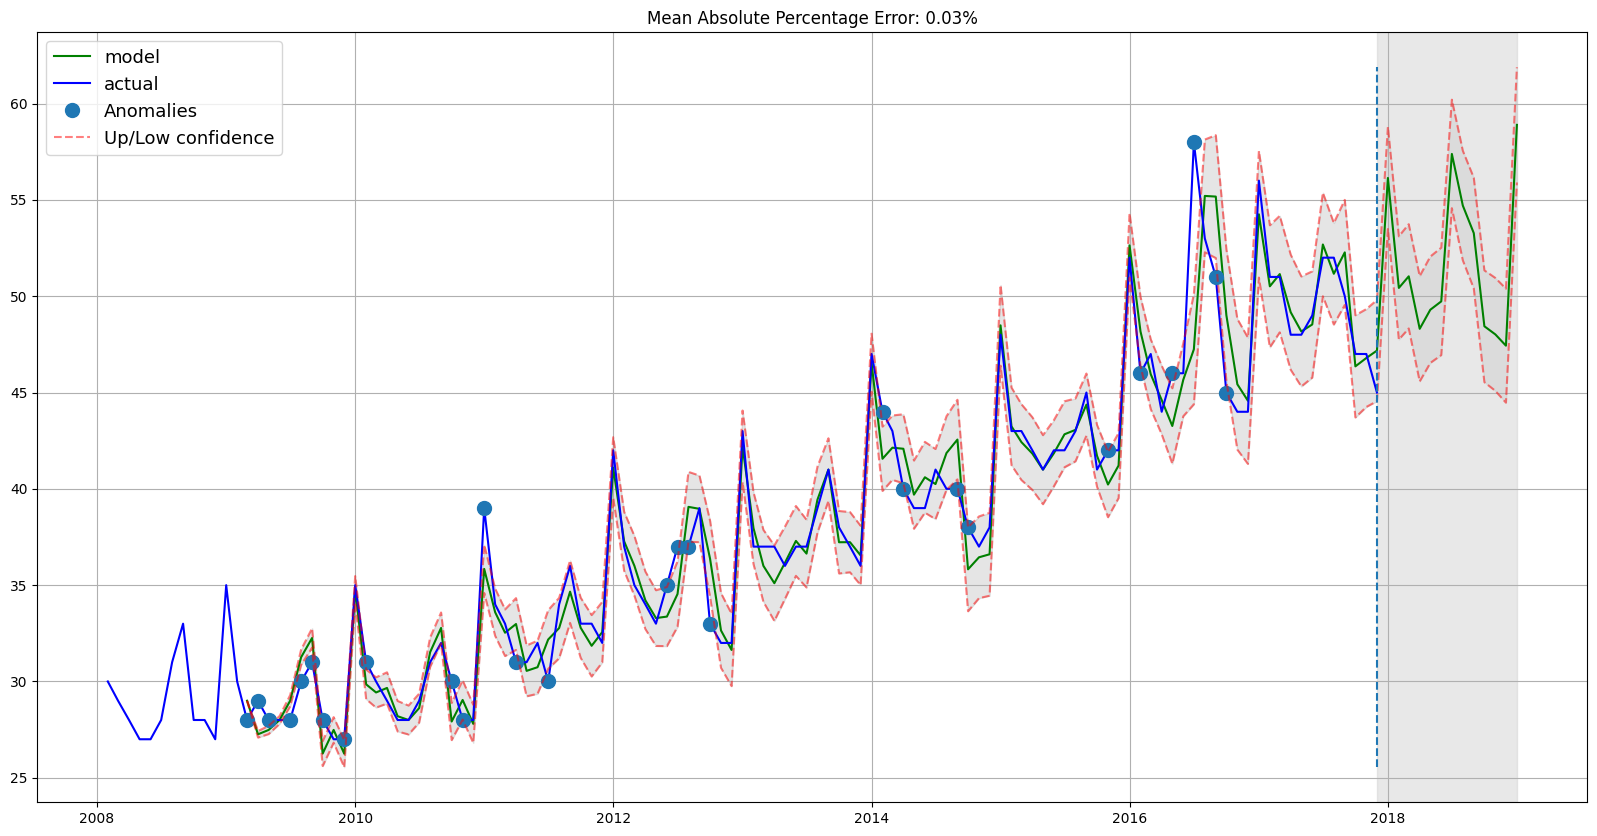

In [28]:
# set the parameters that give the lowest AIC/RMSE
print(result_table.parameters[0])
p, d, q, P, D, Q, S = (2, 1, 0, 2, 1, 0, 12)#result_table.parameters[0]
best_model = SARIMAX(data.gym.iloc[49:], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, S)).fit(disp=False)

print(best_model.summary())

plotSARIMA(data[['gym']].iloc[49:], best_model, 12, S, d, gamma=0.05, plot_anomalies=True, plot_intervals=True)

2. diet

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.647335
p-value                   0.458430
# lags used              13.000000
# observations          154.000000
critical value (1%)      -3.473543
critical value (5%)      -2.880498
critical value (10%)     -2.576878
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


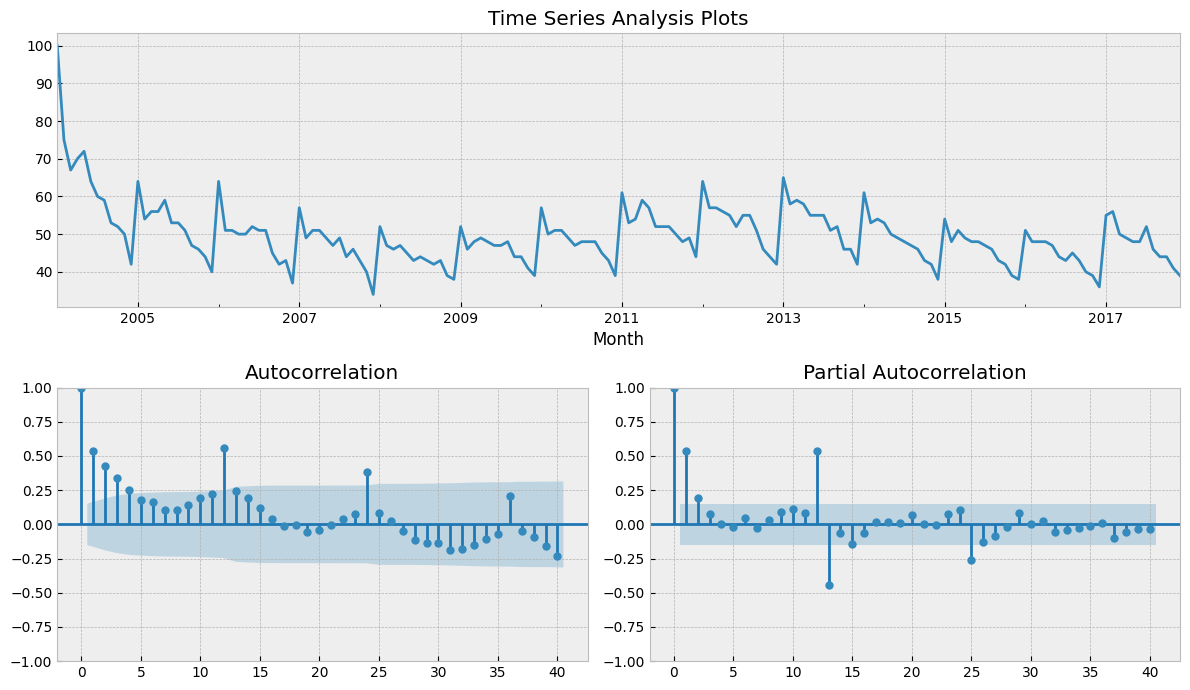

In [14]:
# check variance and trend through first plot
tsplot(diet.diet, lags=40)

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.330427
p-value                   0.162342
# lags used              14.000000
# observations          141.000000
critical value (1%)      -3.477601
critical value (5%)      -2.882266
critical value (10%)     -2.577822
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


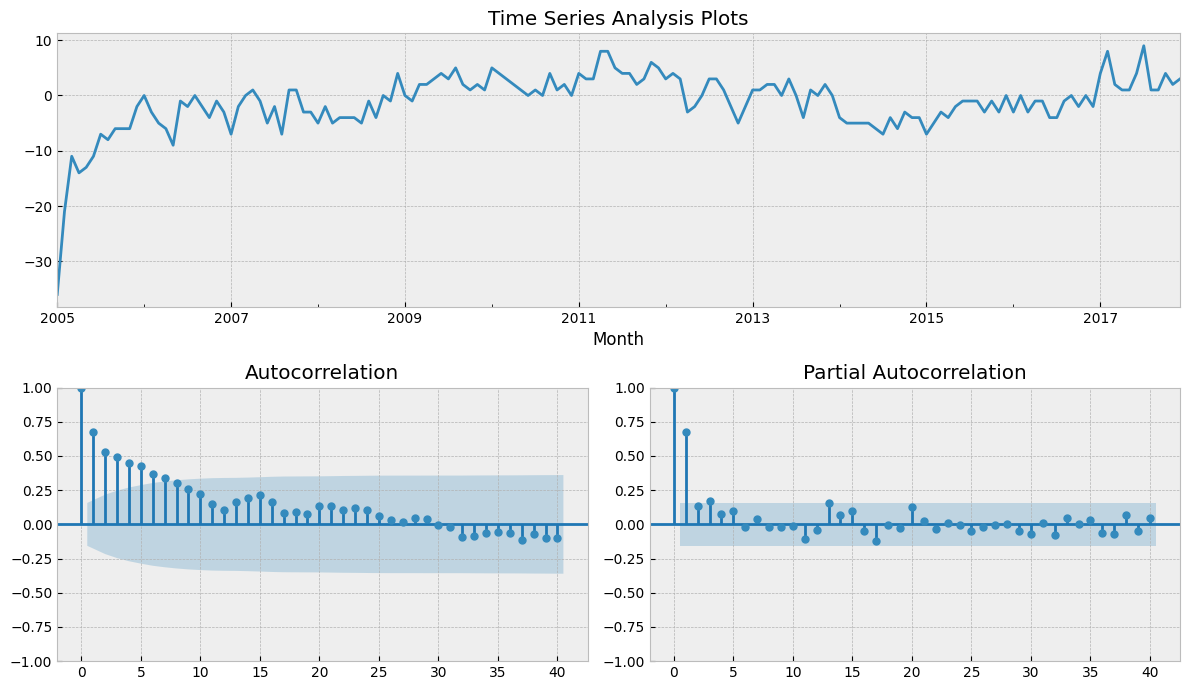

In [15]:
# remove seasonality for 12 months
diet_diff = data.diet.diff(12)
tsplot(diet_diff[12:], lags=40)

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.565005
p-value                   0.000150
# lags used              13.000000
# observations          141.000000
critical value (1%)      -3.477601
critical value (5%)      -2.882266
critical value (10%)     -2.577822
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


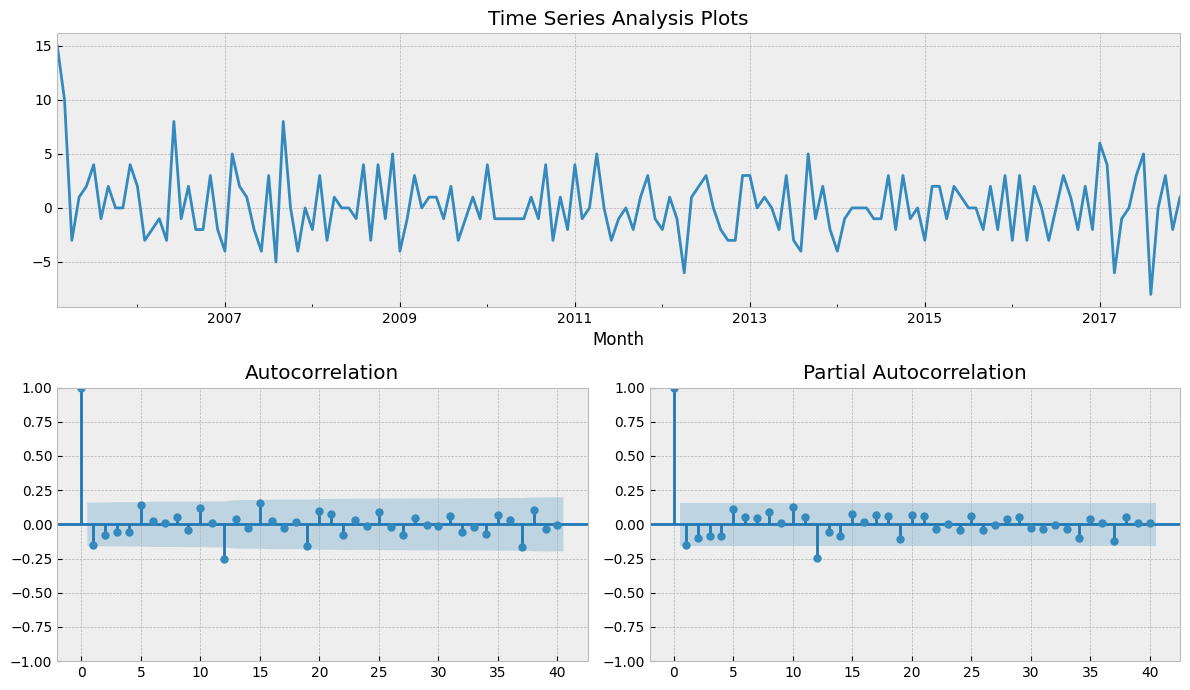

In [16]:
# lets take difference
diet_diff_ = diet_diff.diff(1)
tsplot(diet_diff_[13:], lags=40)

In [24]:
ps = range(1, 5)
d=[1] 
qs = range(1, 5)
Ps = range(0, 3)
D=[1] 
Qs = range(0, 2)
s = [12] # season length is still 1
# creating list with all the possible combinations of parameters
parameters = product(ps, d, qs, Ps, D, Qs, s)
parameters_list = list(parameters)
print(len(parameters_list))
    
train = data.diet.iloc[:-24]
test = data.diet.iloc[-24:]

result_table = getBestOrder(parameters_list, train, test)

96


  0%|          | 0/96 [00:00<?, ?it/s]

ARIMA(1, 1, 1, 0, 1, 0, 12) - AIC:602.2285076153444 - RMSE:3.0810115978360617
ARIMA(1, 1, 1, 0, 1, 1, 12) - AIC:521.0158379373732 - RMSE:3.302623908217189
ARIMA(1, 1, 1, 1, 1, 0, 12) - AIC:532.1816026612805 - RMSE:4.215073775304202
ARIMA(1, 1, 1, 1, 1, 1, 12) - AIC:499.38692696533633 - RMSE:2.5990431289402687
ARIMA(1, 1, 1, 2, 1, 0, 12) - AIC:467.3885543607216 - RMSE:4.015025044755779
ARIMA(1, 1, 1, 2, 1, 1, 12) - AIC:469.2750123343071 - RMSE:3.986094506073018
ARIMA(1, 1, 2, 0, 1, 0, 12) - AIC:600.0391763476638 - RMSE:3.137709118301341
ARIMA(1, 1, 2, 0, 1, 1, 12) - AIC:512.1315460487367 - RMSE:2.940578647129868
ARIMA(1, 1, 2, 1, 1, 0, 12) - AIC:534.272749137083 - RMSE:4.552807420028368
ARIMA(1, 1, 2, 1, 1, 1, 12) - AIC:495.86028079985124 - RMSE:2.5873236191142155
ARIMA(1, 1, 2, 2, 1, 0, 12) - AIC:472.34831794087495 - RMSE:4.354646168791666
ARIMA(1, 1, 2, 2, 1, 1, 12) - AIC:452.27977850486747 - RMSE:2.7167917461447395
ARIMA(1, 1, 3, 0, 1, 0, 12) - AIC:597.1549276024174 - RMSE:3.19632059

(4, 1, 4, 1, 1, 1, 12)
                                      SARIMAX Results                                       
Dep. Variable:                                 diet   No. Observations:                  168
Model:             SARIMAX(4, 1, 4)x(1, 1, [1], 12)   Log Likelihood                -368.913
Date:                              Thu, 25 Apr 2024   AIC                            759.825
Time:                                      13:51:50   BIC                            793.303
Sample:                                  01-01-2004   HQIC                           773.423
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1771      0.090     -1.976      0.048      -0.353      -0.

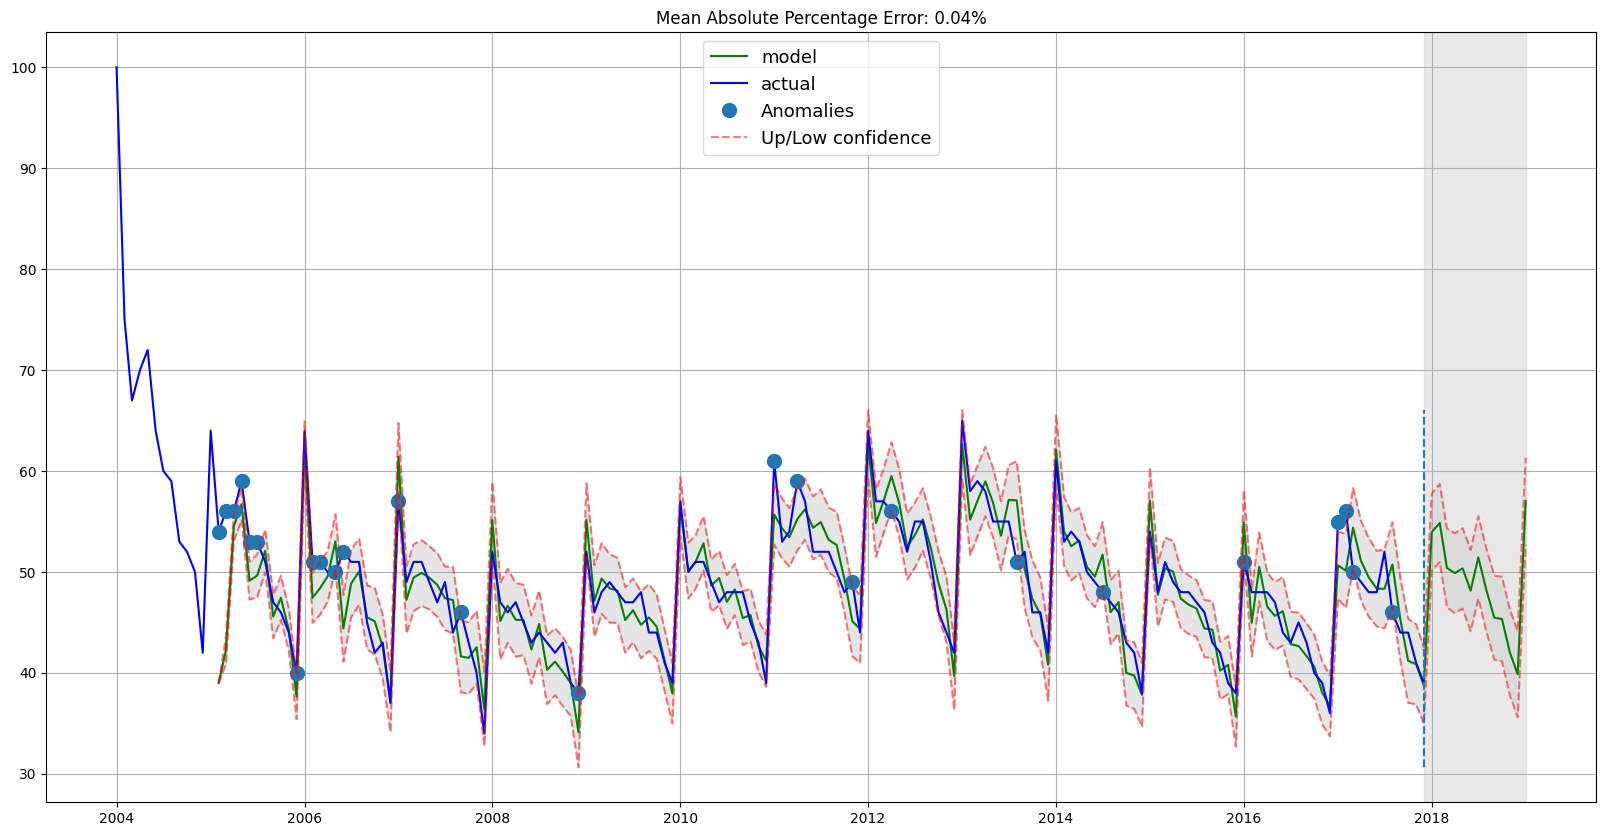

In [25]:
# set the parameters that give the lowest AIC/RMSE
print(result_table.parameters[0])
p, d, q, P, D, Q, S = result_table.parameters[0]
best_model = SARIMAX(data.diet, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, S)).fit(disp=False)

print(best_model.summary())

plotSARIMA(data[['diet']], best_model, 12, S, d, gamma=0.05, plot_anomalies=True, plot_intervals=True)

3. finance

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.745515
p-value                   0.407827
# lags used              12.000000
# observations          155.000000
critical value (1%)      -3.473259
critical value (5%)      -2.880374
critical value (10%)     -2.576812
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


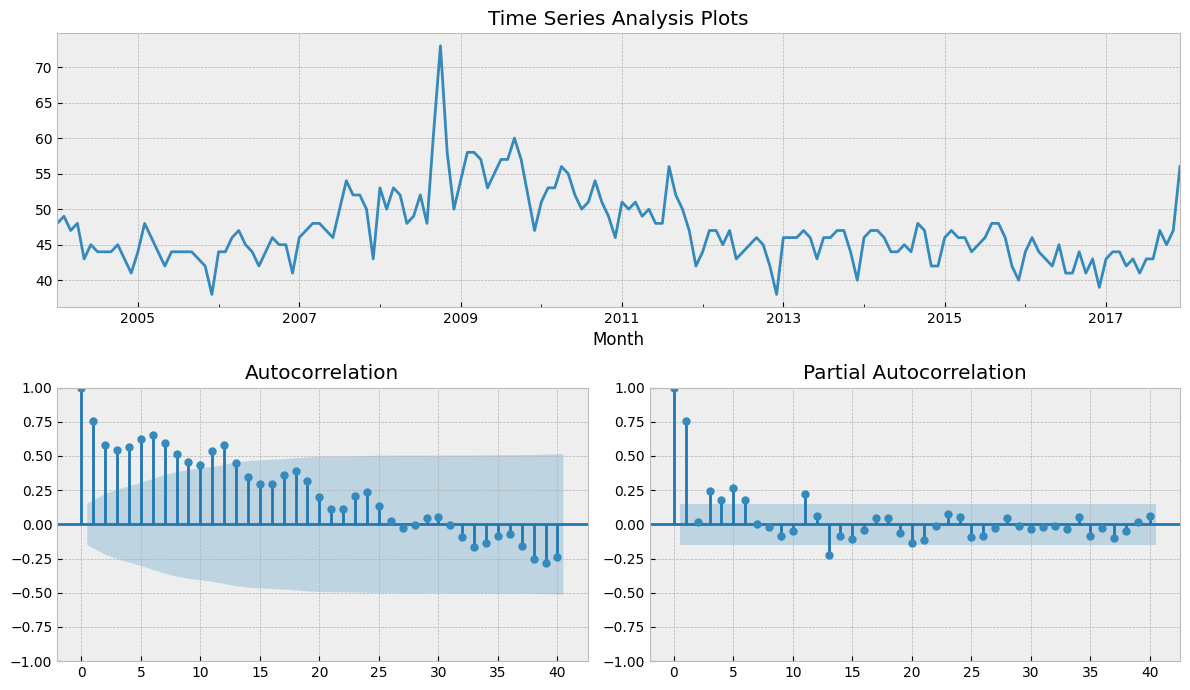

In [30]:
# check variance and trend through first plot
tsplot(data.finance, lags=40)

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.149244
p-value                   0.225180
# lags used              12.000000
# observations          143.000000
critical value (1%)      -3.476927
critical value (5%)      -2.881973
critical value (10%)     -2.577665
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


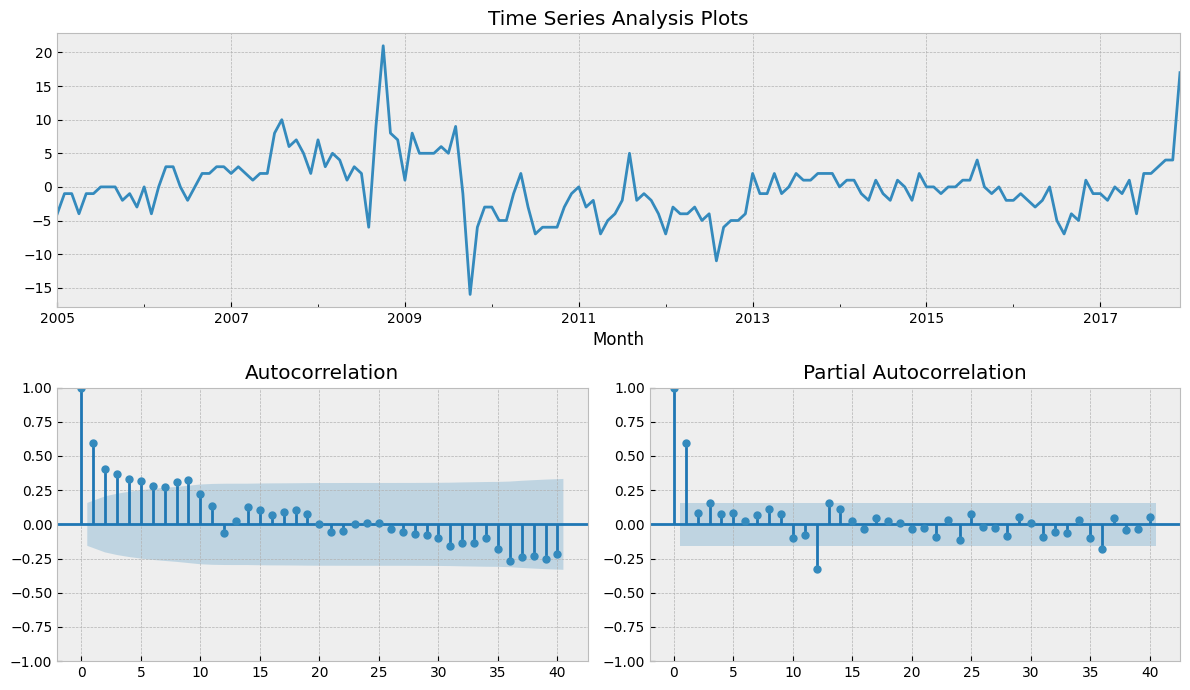

In [34]:
# remove seasonality for 12 months
finance_diff = data.finance.diff(12)
tsplot(finance_diff[12:], lags=40)

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.395384
p-value                   0.011117
# lags used              12.000000
# observations          142.000000
critical value (1%)      -3.477262
critical value (5%)      -2.882118
critical value (10%)     -2.577743
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


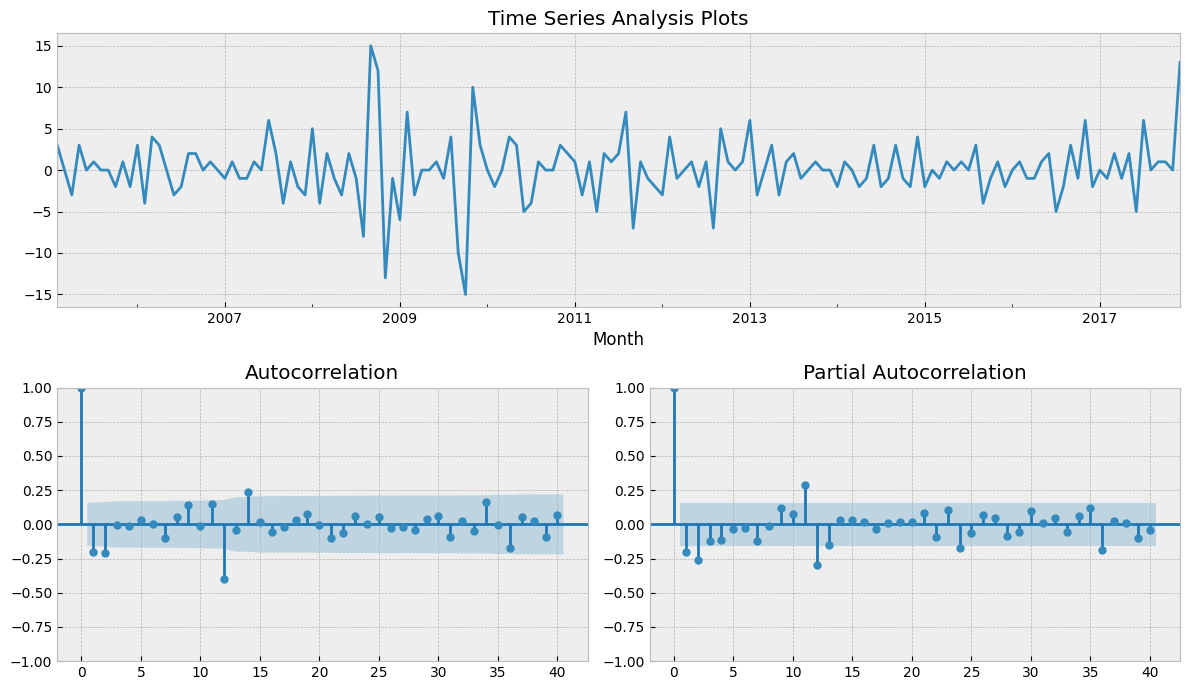

In [35]:
# lets take difference
finance_diff_ = finance_diff.diff(1)
tsplot(finance_diff_[13:], lags=40)

In [36]:
ps = range(1, 5)
d=[1] 
qs = range(1, 5)
Ps = range(0, 3)
D=[1] 
Qs = range(0, 2)
s = [12] # season length is still 1
# creating list with all the possible combinations of parameters
parameters = product(ps, d, qs, Ps, D, Qs, s)
parameters_list = list(parameters)
print(len(parameters_list))
    
train = data.finance.iloc[:-24]
test = data.finance.iloc[-24:]

result_table = getBestOrder(parameters_list, train, test)

96


  0%|          | 0/96 [00:00<?, ?it/s]

ARIMA(1, 1, 1, 0, 1, 0, 12) - AIC:691.2286545420853 - RMSE:4.494033735838647
ARIMA(1, 1, 1, 0, 1, 1, 12) - AIC:582.9956240759623 - RMSE:4.314100876221311
ARIMA(1, 1, 1, 1, 1, 0, 12) - AIC:618.0058528152192 - RMSE:4.312075740066854
ARIMA(1, 1, 1, 1, 1, 1, 12) - AIC:584.9952386312219 - RMSE:4.314033030392676
ARIMA(1, 1, 1, 2, 1, 0, 12) - AIC:561.7603559166147 - RMSE:4.338245952542207
ARIMA(1, 1, 1, 2, 1, 1, 12) - AIC:542.3953719129278 - RMSE:4.405896018735122
ARIMA(1, 1, 2, 0, 1, 0, 12) - AIC:685.4341400896826 - RMSE:4.499415941849505
ARIMA(1, 1, 2, 0, 1, 1, 12) - AIC:576.077967860355 - RMSE:4.303458152020204
ARIMA(1, 1, 2, 1, 1, 0, 12) - AIC:616.3033770553988 - RMSE:4.310190928815849
ARIMA(1, 1, 2, 1, 1, 1, 12) - AIC:577.959026352282 - RMSE:4.3182698708328715
ARIMA(1, 1, 2, 2, 1, 0, 12) - AIC:559.7010847281031 - RMSE:4.354018107702336
ARIMA(1, 1, 2, 2, 1, 1, 12) - AIC:539.1496261685004 - RMSE:4.393287363786442
ARIMA(1, 1, 3, 0, 1, 0, 12) - AIC:682.5644085702069 - RMSE:4.499246183982063


(2, 1, 3, 1, 1, 0, 12)
                                      SARIMAX Results                                      
Dep. Variable:                             finance   No. Observations:                  168
Model:             SARIMAX(2, 1, 3)x(1, 1, [], 12)   Log Likelihood                -399.333
Date:                             Thu, 25 Apr 2024   AIC                            812.666
Time:                                     14:08:56   BIC                            833.970
Sample:                                 01-01-2004   HQIC                           821.319
                                      - 12-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0030      7.198     -0.000      1.000     -14.110      14.104
ar.L

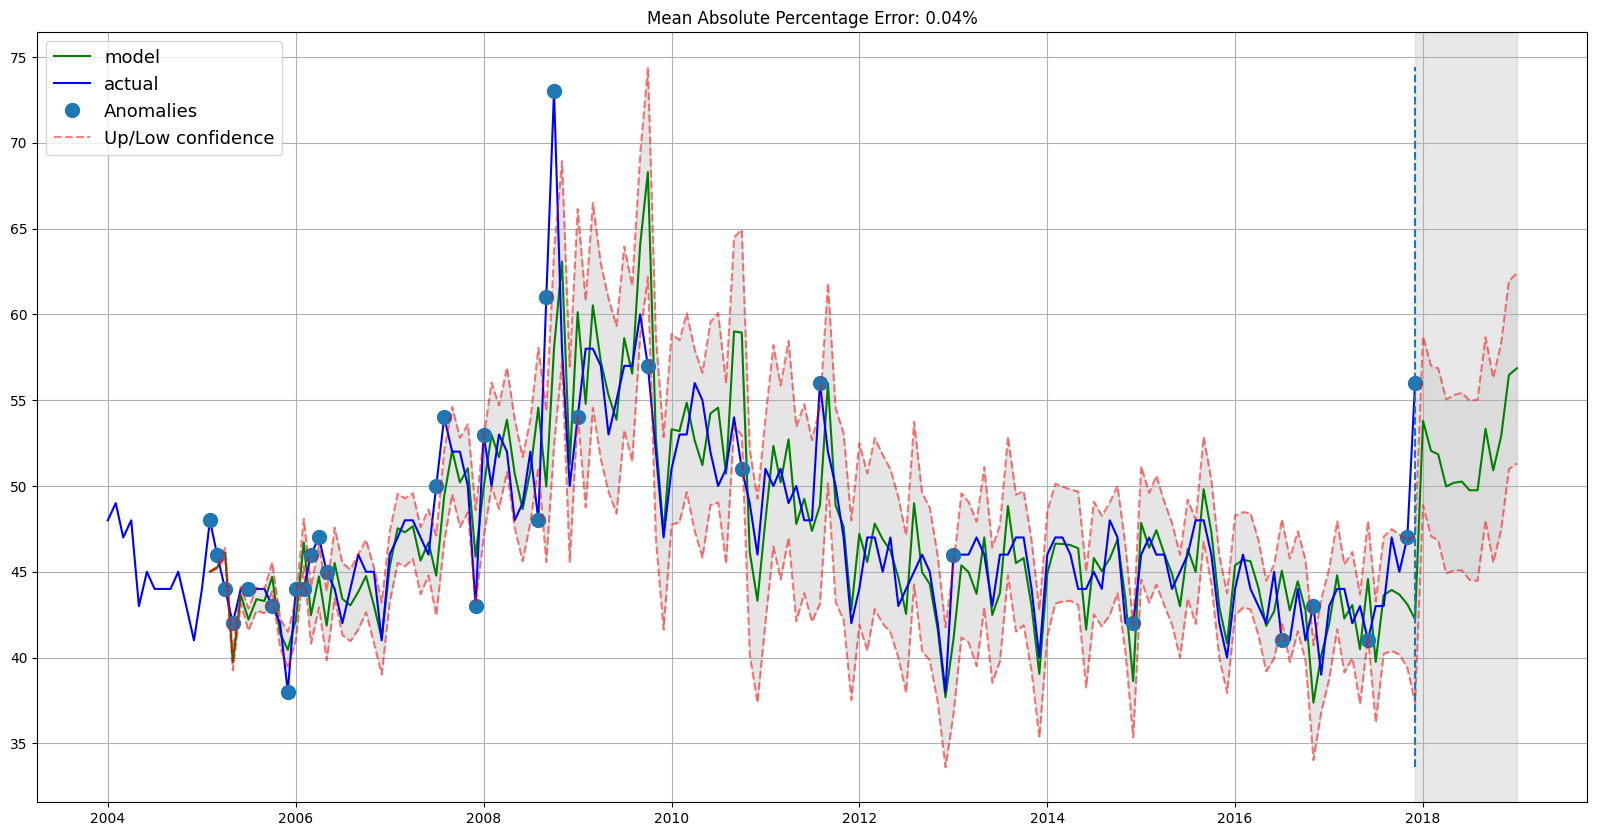

In [38]:
# set the parameters that give the lowest AIC/RMSE
print(result_table.parameters[0])
p, d, q, P, D, Q, S = result_table.parameters[0]
best_model = SARIMAX(data.finance, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, S)).fit(disp=False)

print(best_model.summary())

plotSARIMA(data[['finance']], best_model, 12, S, d, gamma=0.05, plot_anomalies=True, plot_intervals=True)

## non timeseries methods

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [68]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test


def plotModelResults(model, X_train, X_test, y_train, y_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    """
    
    # prediction = model.predict(X_test)
    prediction = pd.Series(model.predict(X_test), index=X_test.index)
    
    plt.figure(figsize=(15, 7))
    plt.plot(y_train, "b", label="training", linewidth=2.0)
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            anomalies = pd.Series(anomalies, index=y_test.index)
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);


def plotCoefficients(model, X_train):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [69]:
df = pd.read_csv("data/multiTimeline.csv", skiprows=2,  parse_dates=['Month'], index_col='Month')
df.columns = ['diet', 'gym', 'finance']

gym = df[['gym']]
finance = df[['finance']]
diet = df[['diet']]

             y  lag_6  lag_7  lag_8  lag_9  lag_10  lag_11  lag_12
Month                                                             
2005-01-01  64   60.0   64.0   72.0   70.0    67.0    75.0   100.0
2005-02-01  54   59.0   60.0   64.0   72.0    70.0    67.0    75.0
2005-03-01  56   53.0   59.0   60.0   64.0    72.0    70.0    67.0
2005-04-01  56   52.0   53.0   59.0   60.0    64.0    72.0    70.0
2005-05-01  59   50.0   52.0   53.0   59.0    60.0    64.0    72.0


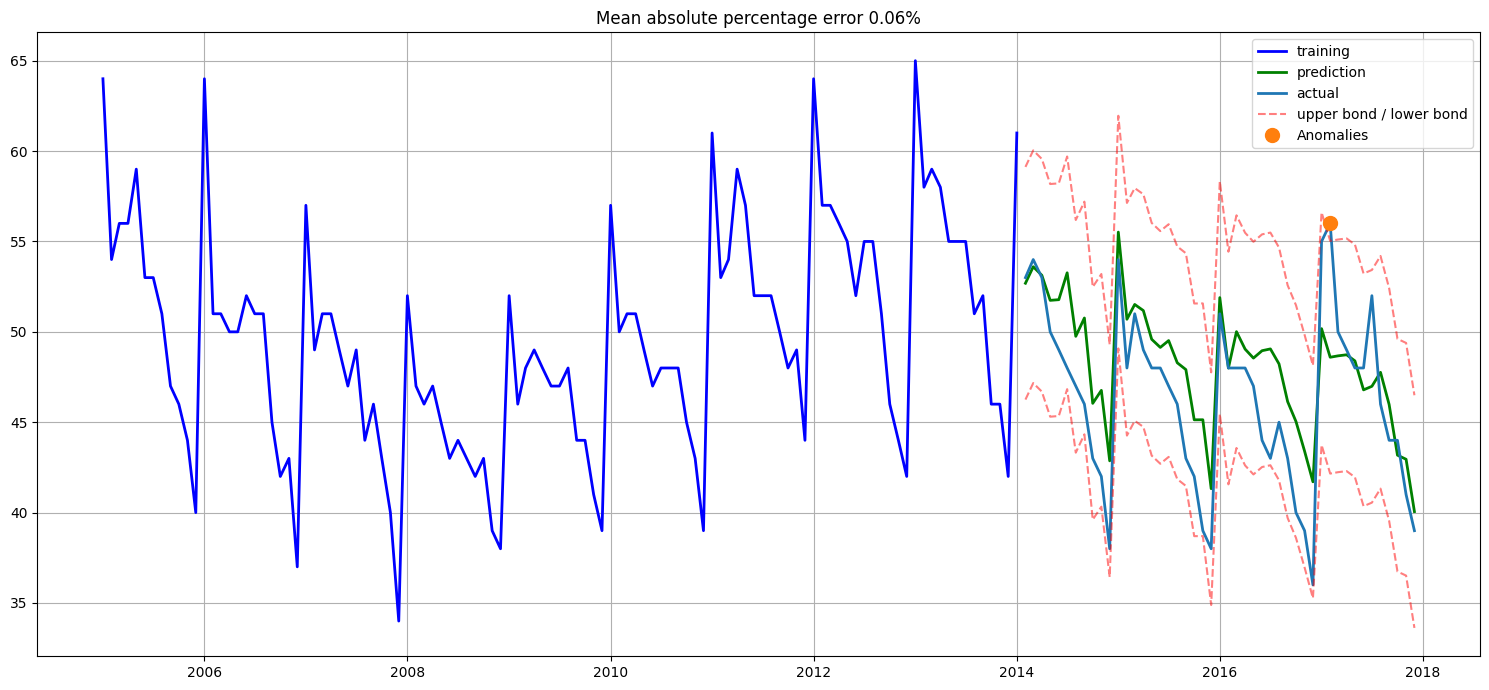

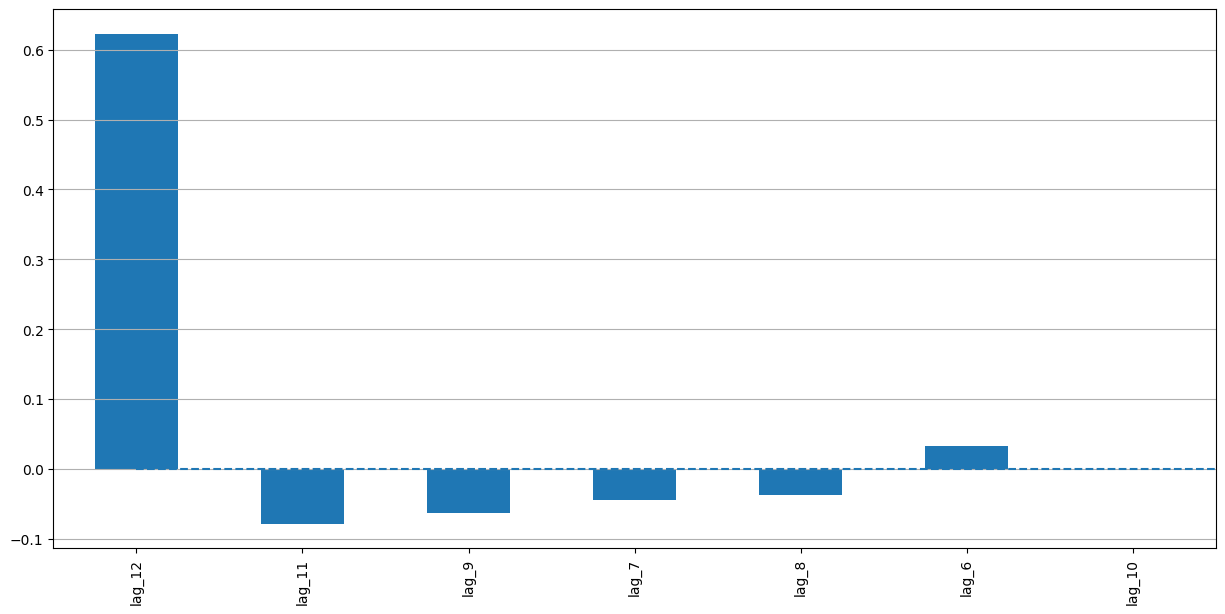

In [77]:
# Creating a copy of the initial dataframe to make various transformations 
data = diet.copy()
data.columns = ["y"]

# Adding the lag of the target variable from 6 steps back up to 12
for i in range(6, 13):
    data["lag_{}".format(i)] = data.y.shift(i)
    

print(data.iloc[12:].head()) # as we are taking 12 lags

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

# machine learning in two lines
model = LinearRegression()
model.fit(X_train, y_train)

plotModelResults(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, plot_intervals=True, plot_anomalies=True)
plotCoefficients(model, X_train)

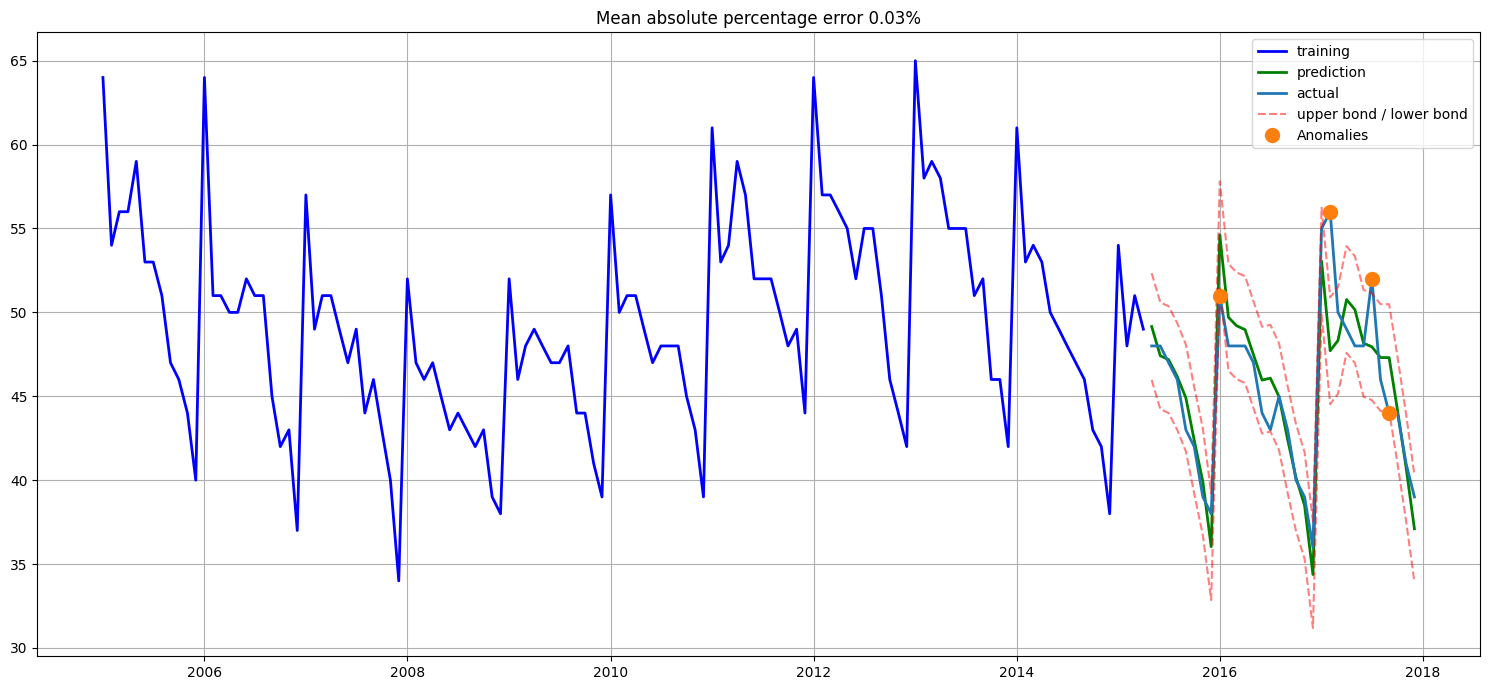

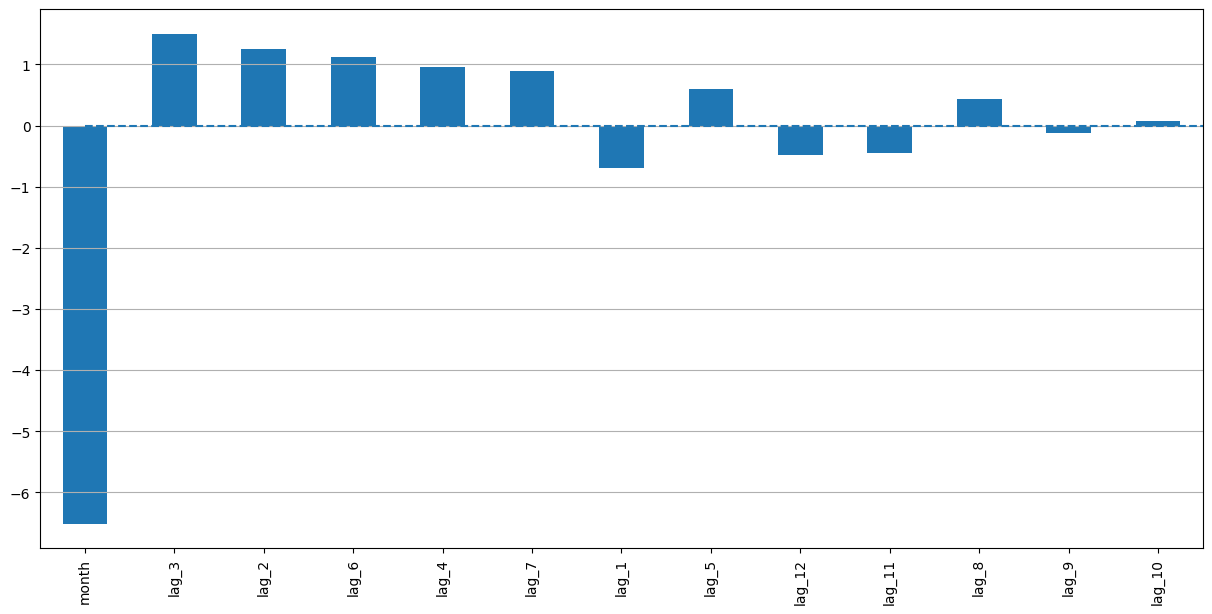

In [84]:
# create few more features
data = diet.copy()
data.columns = ["y"]

# Adding the lag of the target variable from 6 steps back up to 12
for i in range(1, 13):
    data["lag_{}".format(i)] = data.y.shift(i)

data["month"] = data.index.month
# data['year'] = data.index.year
# data['weekday'] = data.index.weekday
# data['is_weekend'] = data.weekday.isin([5,6])*1

scaler = StandardScaler()

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.2)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

plotModelResults(model, X_train=X_train_scaled, X_test=X_test_scaled, y_train=y_train, y_test=y_test, plot_intervals=True, plot_anomalies=True)
plotCoefficients(model, X_train)
